## Analyzing the Impact of TELs on Debt Issues

This Notebook uses the data constructed in [sas2csv](https://github.com/choct155/TELs_debt/blob/master/code/sas2csv.ipynb) and [DebtDataSeries](https://github.com/choct155/TELs_debt/blob/master/code/DebtDataSeries.ipynb) to evaluate the impact of tax and expenditure limitations on debt issues by county.  This Notebook will do the following:

1. Subset to the variables critical to our analysis (**Data Input**);
2. Build specifications that feature a set of debt related dependent variables (**Model Design**);
3. Estimate the relationship between TELs and debt by way of pooled and fixed effect models (**Estimation**).

In [304]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.io.data as web

rcParams['axes.edgecolor']='k'
rcParams['patch.facecolor']='w'
rcParams['axes.facecolor']='w'
rcParams['axes.linewidth']=1

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Data Input

Our data is housed in ... the **`data/`** directory.  We are looking for `debt_out.csv` which has aggregate debt issue, institutional, socioeconomic, and spatial information aggregated to the county level.

In [149]:
!ls -l ../data/

total 381192
-rw-r--r-- 1 root     root       165888 Nov 10 17:20 13slsstab1a.xls
-rw-r--r-- 1 root     root        93112 Nov 10 17:20 2013_GFS_debt.xcf
-rw-r--r-- 1 root     root     12226235 Nov 10 17:20 bonds.csv
-rwxr-xr-x 1 root     root     78722993 Nov 15 16:10 costat_mod_vars1940_2010.csv
-rwxr-xr-x 1 root     root      2960775 Nov 15 16:13 cty_coverage.csv
-rw-r--r-- 1 root     root            0 Nov 10 17:20 current_issue_geocode_list.csv
-rw-r--r-- 1 root     root     57033106 Nov 15 15:36 debt_mod_std.csv
-rwxr-xr-x 1 root     root     55859853 Nov 15 16:13 debt_out.csv
-rw-r--r-- 1 root     root     47620501 Nov 10 17:20 debt_ts_pre_fips.csv
-rw-r--r-- 1 root     root     46996855 Nov 15 16:13 debt_w_fips.csv
-rw-r--r-- 1 root     root     56013396 Nov 15 16:13 debt_w_int.csv
-rw-r--r-- 1 root     root      1471282 Nov 15 14:12 Descriptives.csv
-rw-r--r-- 1 root     root       104148 Nov 10 17:20 fips_st_co_02_07.csv
-rw-r----- 1 choct155 choct155      686 Nov 14 21:31 FRB_

Let's go ahead and read in the data.

In [150]:
#Read in data
# data_in=pd.read_csv('../data/debt_out.csv')
data_in=pd.read_csv('../data/debt_w_int.csv')

#Generate variable that captures gap between general revenue and direct general expenditure, normalized by exp
data_in['OSRC_GAP']=(data_in['GEN_REV']-data_in['D_GEN_EXP'])/data_in['D_GEN_EXP']

#Generate general revenue per capita variable
data_in['GEN_REV_PC']=data_in['GEN_REV']/data_in['RESPOP']

#Generate tax effort variable
data_in['TAX_EFFORT']=data_in['GEN_REV_PC']/data_in['PC_INC']

#Capture issuer suffixes
issuers=['City, Town Vlg','Co-op Utility','County/Parish','Direct Issuer','District',\
         'Indian Tribe','Local Authority']
purposes=['Development','Education','Electric Power','Environmental Facilities','General Purpose','Healthcare',\
          'Housing','Public Facilities','Transportation','Utilities']

#Define replacement suffixes
issuers_new=['GEN_MUNI','COOP_UTIL','CTY','DIRECT','DISTRICT','TRIBE','LOC_AUTH']
purposes_new=['DEV','EDUC','ELECTRIC','ENVIRON','GEN_PUR','HEALTH','HOUS','PUB_FAC','TRANSPORT','UTIL']

#Capture lists of old and new name pairings
goi=zip(['GO_'+var for var in issuers],['GO_'+var for var in issuers_new])
gop=zip(['GO_'+var for var in purposes],['GO_'+var for var in purposes_new])
rvi=zip(['RV_'+var for var in issuers],['RV_'+var for var in issuers_new])
rvp=zip(['RV_'+var for var in purposes],['RV_'+var for var in purposes_new])

#Build renaming dict
rename_dict=dict(goi+gop+rvi+rvp)

#Rename relevant variables
data_in=data_in.rename(columns=rename_dict)
print 'Before subset:',len(data_in)

#Subset to non-null values of RESPOP and counties in MSAs
data_in=data_in[(data_in['RESPOP'].notnull()) & (data_in['MSA']==1)]
print 'After subset:',len(data_in)
print 'The vast majority of observations lost (all but maybe 100) come in 2011 on (after COSTAT data ends)'

print sorted(data_in.columns),'\n\n',data_in.info()

Before subset: 59669
After subset: 23658
The vast majority of observations lost (all but maybe 100) come in 2011 on (after COSTAT data ends)
['ASMT_L', 'ASMT_L2', 'ASMT_L3', 'BOTH', 'CB_E', 'CB_E2', 'CB_E3', 'CB_E4', 'CB_G', 'CB_G2', 'CFDISC_L', 'CGEXP_L', 'CH_HS_UNT', 'CLEVY_L', 'CLEVY_L2', 'CLEVY_L3', 'CLEVY_L4', 'CRATE_L', 'CRATE_L2', 'CREVU_L', 'CTY_INTEREST', 'DENSITY', 'DIVERSITY', 'D_GEN_EXP', 'EDUC_SERV_EMP_PNFARM', 'EMP_RES', 'FFDISC_L', 'FIPS', 'FIPSST', 'FIPST_N', 'FOOD_SERV_EMP_PNFARM', 'GEN_REV', 'GEN_REV_PC', 'GEXP_L', 'GO', 'GO_COOP_UTIL', 'GO_CTY', 'GO_DEV', 'GO_DIRECT', 'GO_DISTRICT', 'GO_EDUC', 'GO_ELECTRIC', 'GO_ENVIRON', 'GO_GEN_MUNI', 'GO_GEN_PUR', 'GO_HEALTH', 'GO_HOUS', 'GO_LOC_AUTH', 'GO_PUB_FAC', 'GO_TRANSPORT', 'GO_TRIBE', 'GO_UTIL', 'GP_GEXP', 'GP_LEVY', 'GP_LMT', 'GP_RATE', 'GP_REVU', 'HOME_STEAD', 'HOME_STEAD2', 'HOME_STEAD3', 'HSG_UNITS', 'HSG_UNITS_ACS', 'HSLD_PERS', 'IGR_ST', 'LANDAREA', 'LEVY_L', 'LIMITS', 'MANU_EMP_PNFARM', 'MANU_RES', 'MDHOMEVAL', 'ME

In [151]:
data_in[['GEN_REV','D_GEN_EXP','OSRC_GAP']]

,GEN_REV,D_GEN_EXP,OSRC_GAP
5,23020.4,20952.0,0.098721
6,30817.8,26915.6,0.144979
7,32131.6,29090.2,0.104551
8,33445.4,31264.8,0.069746
9,36073.0,35614.0,0.012888
10,40466.0,43001.6,-0.058965
11,44859.0,50389.2,-0.109750
12,53645.0,65164.4,-0.176774
13,58038.0,72552.0,-0.200050
14,63978.2,75520.0,-0.152831


In [152]:
print len(data_in[pd.isnull(data_in).any(axis=1)]),len(data_in)
print len(data_in[pd.isnull(data_in).any(axis=1)])/float(len(data_in))

783 23658
0.0330966269338


Subset to complete cases.

In [153]:
print 'Before subset:',len(data_in)
data_in=data_in[pd.notnull(data_in).all(axis=1)]
print 'After subset:',len(data_in)

Before subset: 23658
After subset: 22875


The set of variables in play appear in the table below:

**DEPENDENT VARIABLES**

Concept|Input Variables
-------|---------------
Per capita GO debt issued|*Variables beginning with GO* & `RES_POP`
Per capita revenue debt issued|*Variables beginning with RV* & `RES_POP`
Ratio of GO to revenue debt issued|*Variables beginning with GO or RV*

**INSTITUTIONAL VARIABLES**

Concept|Input Variables
-------|---------------
Any TEL|`LIMITS`
Non-binding TEL|`TYPE1`
Potentially binding TEL|`TYPE2`
Both `TYPE1` & `TYPE2`|`BOTH`
Years since `TYPE2` enacted|`TYPE2_y`
Overall property tax rate limit|`RATE_L`
Overall assessment limit|`SC_LMT`
Limit applied to general purpose gov|`GP_LMT`
Limit applied to school district|`SC_LMT`

*Note that all limits above can be interacted with primary county status (`PRIMARY`; see spatial table below), in which case we append an `i` to the variable name.*

**SCALE & SUPPLY MEASURES**

Concept|Input Variables
-------|---------------
Population|`RES_POP`
<span style="color:red">Population$^2$</span>|`RES_POP2`
Population density|`DENSITY`
Population growth rate|`POPGROW`
Household size|`PERS_HLD`
Pre-1940 housing stock|`PRE1940`

**DEMAND MEASURES**

Concept|Input Variables
-------|---------------
Population under 17|`PYOUNG`
Private school enrollment|`PVT_SCH`
Population over 65|`POP65`
Per capita income|`PCINC`
Povery rate|`POVERTY`
Average monthly Social Security payments (to recipients)|`PC_SSI`
Per capita income weighted by poverty rate|`DIVERSITY`

**ECONOMIC ACTIVITY**

Concept|Input Variables
-------|---------------
Employment to population ratio|`EMP_RESI`
Manufacturing employment to population ratio|`MANU_RES`
Retail employment to population ratio|`RETL_RES`
Service employment to population ratio|`SERV_RES`

**SPATIAL CHARACTERISTICS**

Concept|Input Variables
-------|---------------
Primary central county in 1974|`PRIMARY`
Co-central county in 1974|`CO_PRIM`
Urban fringe county in 1974|`FRINGE`

Let's grab these in category lists to make them more accessible.

In [154]:
#Capture dependent variables
debt_vars=['GO','RV']
go_vars={'iss':['GO_'+var for var in issuers_new],
         'pur':['GO_'+var for var in purposes_new]}
rv_vars={'iss':['RV_'+var for var in issuers_new],
         'pur':['RV_'+var for var in purposes_new]}

#Capture independent vars
tel_vars={'types':['TYPE1','TYPE2','TYPE2_Y'],
          'either':['LIMITS','BOTH'],
          'hi_res':['RATE_L','ASMT_L','GP_LMT','SC_LMT']}
supply_vars=['RESPOP','DENSITY','POPGROWTH','HSLD_PERS','PRE1940']
demand_vars=['PYOUNG','PVT_SCH','POP65','PC_INC','POVERTY','PC_SSI','DIVERSITY']
economic_vars=['EMP_RES','MANU_RES','RETL_RES','SERV_RES','CTY_INTEREST']
spatial_vars=['PRIMARY','CO_PRIM','FRINGE']
fiscal_vars=['GEN_REV','OSRC_GAP','TAX_EFFORT','IGR_ST','TOT_DEBT_OUTST']

#Capture all modeling variables in a single list
mod_vars=debt_vars+go_vars['iss']+go_vars['pur']+rv_vars['iss']+rv_vars['pur']+tel_vars['types']+\
         tel_vars['either']+tel_vars['hi_res']+supply_vars+demand_vars+economic_vars+spatial_vars+fiscal_vars
    
#For each model variable...
for var in mod_vars:
    #...tell me if it's not in the set
    if var not in data_in.columns:
        print "Is "+var+" in the data set??  Maaaan, we ain't found shit!"
        
#Capture model subset
data=data_in[[var for var in mod_vars if var in data_in.columns]+['Year','FIPS']]

#Generate populations squared
data['RESPOP2']=data['RESPOP']**2

data.head().T

Is PRIMARY in the data set??  Maaaan, we ain't found shit!
Is CO_PRIM in the data set??  Maaaan, we ain't found shit!
Is FRINGE in the data set??  Maaaan, we ain't found shit!


/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,7,8,9,10,11
GO,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,4.340000e+00
RV,0.000000e+00,2.200000e+00,4.450000e+00,4.545000e+00,1.365000e+00
GO_GEN_MUNI,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,4.340000e+00
GO_COOP_UTIL,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_CTY,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_DIRECT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_DISTRICT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_TRIBE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_LOC_AUTH,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
GO_DEV,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [155]:
print len(data[pd.isnull(data).any(axis=1)]),len(data)
print len(data[pd.isnull(data).any(axis=1)])/float(len(data))

0 22875
0.0


### Accounting for Inflation

The first thing we need to do is adjust all of the dollar figures for inflation.  The relevant variables are in the following list.

In [156]:
#Capture debt variables
debt_vars=[var for var in data.columns if var.startswith('GO')]+\
          [var for var in data.columns if var.startswith('RV')]

#Capture variables to be deflated
defl_vars=debt_vars+['PC_INC','PC_SSI','DIVERSITY']

We need to pull an index for deflation.  To be consistent with the descriptive analysis, we will use the PCE deflator from [FRED](https://research.stlouisfed.org/fred2/).  Specifically, we are using the chained PCE deflator ([PCECTPI](https://research.stlouisfed.org/fred2/)).  We can pull that directly with pandas FRED API and use it to deflate our data.

**UPDATE** We are converting to the state and local government implicit price deflator (`A829RD3A086NBEA`).  The mechanics are the same as with the PCE, so we are leaving the code undisturbed.  Note that the SLD increases faster than the PCE.

In [157]:
#Capture PCE
# pce=web.DataReader("PCECTPI","fred",'1/1/1980','1/1/2015').reset_index()
pce=web.DataReader("A829RD3A086NBEA","fred",'1/1/1980','1/1/2015').reset_index()

#Pull out year
pce['Year']=pce['DATE'].apply(lambda x: x.year)

#Set index
pce.set_index('Year',inplace=True)

#Drop date
pce.pop('DATE')

#Capture average by year
pce=pce.groupby(level='Year').mean()

#Calculate deflators
# pce['defl']=pce['PCECTPI'].apply(lambda x: pce['PCECTPI'].ix[2009]/x)
pce['defl']=pce['A829RD3A086NBEA'].apply(lambda x: pce['A829RD3A086NBEA'].ix[2009]/x)

#Map deflator into data via Year
data['defl']=data['Year'].map(pce['defl'])

print pce.head()

data[['Year','defl']].head(20)

      A829RD3A086NBEA      defl
Year                           
1980           32.583  3.069085
1981           35.824  2.791425
1982           38.012  2.630748
1983           39.700  2.518892
1984           41.407  2.415051


/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Year,defl
7,1989,1.988941
8,1990,1.894513
9,1992,1.766753
10,1993,1.722683
11,1994,1.678049
12,1996,1.596755
13,1997,1.562598
14,1998,1.531745
15,1999,1.473297
16,2000,1.405284


With the deflators in hand, we can loop through a copy of the data and generate deflated versions of the contents of `defl_vars`.

In [196]:
#Create a data copy to hold deflated values
data_d=data.copy(deep=True)

#For each var to be deflated...
for var in defl_vars:
    #....deflate the variable
    data_d[var]=data_d[var]*data_d['defl']

print data[['GO','RV','Year','defl']].head()    
print '\n',data_d[['GO','RV','Year','defl']].head()

      GO     RV  Year      defl
7   0.00  0.000  1989  1.988941
8   0.00  2.200  1990  1.894513
9   3.00  4.450  1992  1.766753
10  0.00  4.545  1993  1.722683
11  4.34  1.365  1994  1.678049

          GO        RV  Year      defl
7   0.000000  0.000000  1989  1.988941
8   0.000000  4.167930  1990  1.894513
9   5.300260  7.862052  1992  1.766753
10  0.000000  7.829592  1993  1.722683
11  7.282735  2.290537  1994  1.678049


In [197]:
print len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)
print len(data_d[pd.isnull(data_d).any(axis=1)])/float(len(data_d))

0 22875
0.0


### Accounting for the Business Cycle

We also need to grab recessionary dates, but some assumptions are required since those are tracked on an monthly basis.  Our imperfect approach will be to treat an year with a majority of months in recession as being a recessionary year.  Since the annual average leaves us with the proportion of recessionary months, a recessionary year is any one in which the average exceeds 0.5.

In [198]:
#Capture recessionary dates
usrec=web.DataReader("USREC","fred",'1/1/1980','1/1/2015').reset_index()

#Pull out year
usrec['Year']=usrec['DATE'].apply(lambda x: x.year)

#Set index
usrec.set_index('Year',inplace=True)

#Drop date
usrec.pop('DATE')

#Capture average by year
usrec=usrec.groupby(level='Year').mean()

#Calculate binary recession variable
usrec['BIN_REC']=np.where(usrec['USREC']>=.5,1,0)

#Map bin_rec into data via Year
data_d['BIN_REC']=data_d['Year'].map(usrec['BIN_REC'])

print usrec.head()

print data_d[['Year','BIN_REC']].head()
print data_d[data_d['Year']==2001][['Year','BIN_REC']].head()

         USREC  BIN_REC
Year                   
1980  0.500000        1
1981  0.416667        0
1982  0.916667        1
1983  0.000000        0
1984  0.000000        0
    Year  BIN_REC
7   1989        0
8   1990        0
9   1992        0
10  1993        0
11  1994        0
     Year  BIN_REC
17   2001        1
48   2001        1
98   2001        1
180  2001        1
255  2001        1


In [199]:
print len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)
print len(data_d[pd.isnull(data_d).any(axis=1)])/float(len(data_d))

0 22875
0.0


## Capturing the Prevailing Interest Rate

The prevailing interest rate speaks to the supply of money, and is therefore a useful indicator to understand the macro context.  The coupon rate is missing all values in the raw data, so we will use the 30-year treasury as a proxy.  The inflation-adjusted history is short, so we will manually adjust the nominal rates.  The Federal Reserve has [data on historic market yield of US Treasuries at 30-year constant maturity](http://www.federalreserve.gov/releases/h15/data.htm).  This data has been downloaded and placed in `../data/`.  The [inflation adjustment](https://research.stlouisfed.org/fred2/series/FPCPITOTLZGUSA) to calculate the real rate of interest comes from FRED.

In [200]:
#Read in data
treas30=pd.read_csv('../data/FRB_TREAS_30YR.csv',skiprows=6,header=None,names=['Year','RATE'])

#Replace ND with null values
treas30['RATE']=treas30['RATE'].str.replace('ND','')

#Convert RATE to float
def to_float(x):
    if x!='':
        return float(x)
    else:
        return np.NaN

# treas30['RATE'].apply(lambda x: to_float(x)) NOT WORKING FOR SOME REASON

#Generate float version of RATE
treas30['RATE']=[to_float(val) for val in treas30['RATE']]

#Interpolate for missing values
treas30['RATE']=treas30['RATE'].interpolate()

#Set index
# treas30.set_index('Year',inplace=True)

#Capture CPI
cpi=web.DataReader("FPCPITOTLZGUSA","fred",'1/1/1980','1/1/2015').reset_index()

#Pull out year
cpi['Year']=cpi['DATE'].apply(lambda x: x.year)

#Set index
cpi.set_index('Year',inplace=True)

#Drop date
cpi.pop('DATE')

#Capture average by year
cpi=cpi.groupby(level='Year').mean()

#Join inflation to rate data
treas30['INFLAT']=treas30['Year'].map(cpi['FPCPITOTLZGUSA'])

#Calculate real rate of interest
treas30['REAL_RATE']=treas30['RATE']-treas30['INFLAT']

#Set index
treas30.set_index('Year',inplace=True)

#Map REAL_RATE into data via Year
data_d['REAL_RATE']=data_d['Year'].map(treas30['REAL_RATE'])

#Map INFLAT into data by year
data_d['INFLAT']=data_d['Year'].map(treas30['INFLAT'])

#Create new real interest rate by county
data_d['R_CTY_INT']=data_d['CTY_INTEREST']-data_d['INFLAT']

#Capture difference between prevailing interest rate and county rate
data_d['R_CTY_INT_DIFF']=data_d['REAL_RATE']-data_d['R_CTY_INT']

data_d[['Year','REAL_RATE','CTY_INTEREST','INFLAT','R_CTY_INT','R_CTY_INT_DIFF']].head()

,Year,REAL_RATE,CTY_INTEREST,INFLAT,R_CTY_INT,R_CTY_INT_DIFF
7,1989,3.622997,6.891819,4.827003,2.064816,1.558181
8,1990,3.212044,6.838500,5.397956,1.440544,1.771500
9,1992,4.641180,4.483000,3.028820,1.454180,3.187000
10,1993,3.638343,5.676000,2.951657,2.724343,0.914000
11,1994,4.762558,6.269296,2.607442,3.661854,1.100704


We also need to capture the difference in the prevailing real interest rate.

In [201]:
print len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)
print len(data_d[pd.isnull(data_d).any(axis=1)])/float(len(data_d))

0 22875
0.0


In [203]:
#Set index
data_d_tmp=data_d.set_index(['FIPS'])

#Create container for bad counties
bad_cty=[]

#Create container for subsets
dd_subs=[]

#For each county...
for cty in sorted(set(data_d_tmp.index)):
    #...capture subset...
    dd_sub=data_d_tmp.ix[cty]
    #...redefine county...
    dd_sub['FIPS']=cty
    #...define the change in real interest rates...
    if len(shape(dd_sub))>1:
        dd_sub['REAL_RATE_CHANGE']=dd_sub['REAL_RATE'].diff()
        #...and throw the subset back in the list
        dd_subs.append(dd_sub)
    else:
        print dd_sub
        bad_cty.append(cty)
    
#Concatenate back together
data_d=pd.concat(dd_subs)

/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GO                5.588644e+00
RV                0.000000e+00
GO_GEN_MUNI       0.000000e+00
GO_COOP_UTIL      0.000000e+00
GO_CTY            0.000000e+00
GO_DIRECT         0.000000e+00
GO_DISTRICT       5.588644e+00
GO_TRIBE          0.000000e+00
GO_LOC_AUTH       0.000000e+00
GO_DEV            0.000000e+00
GO_EDUC           0.000000e+00
GO_ELECTRIC       0.000000e+00
GO_ENVIRON        0.000000e+00
GO_GEN_PUR        0.000000e+00
GO_HEALTH         0.000000e+00
GO_HOUS           0.000000e+00
GO_PUB_FAC        5.588644e+00
GO_TRANSPORT      0.000000e+00
GO_UTIL           0.000000e+00
RV_GEN_MUNI       0.000000e+00
RV_COOP_UTIL      0.000000e+00
RV_CTY            0.000000e+00
RV_DIRECT         0.000000e+00
RV_DISTRICT       0.000000e+00
RV_TRIBE          0.000000e+00
RV_LOC_AUTH       0.000000e+00
RV_DEV            0.000000e+00
RV_EDUC           0.000000e+00
RV_ELECTRIC       0.000000e+00
RV_ENVIRON        0.000000e+00
                      ...     
DENSITY           4.547754e+01
POPGROWT

/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [204]:
bad_cty

[22037, 37103, 37115, 48059, 50011, 51157, 54051, 54079, 54105]

In [206]:
print len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)
print len(data_d[pd.isnull(data_d).any(axis=1)])/float(len(data_d))

1050 22866
0.0459197061139


In [207]:
data_d=data_d[pd.notnull(data_d).all(axis=1)]
print len(data_d[pd.isnull(data_d).any(axis=1)])

0


### Mapping in State Labels

Just for facilitating the reading of results, state labels would be useful.  Here is a mapping from that FIPS codes.

In [208]:
#Capture state FIPS codes
data_d['FIPSST']=data_d['FIPS'].apply(lambda x: str(x).zfill(5)[:2])

#Map FIPS to state
fips_st_map={'01': 'AL',
             '02': 'AK',
             '04': 'AZ',
             '05': 'AR',
             '06': 'CA',
             '08': 'CO',
             '09': 'CT',
             '10': 'DE',
             '11': 'DC',
             '12': 'FL',
             '13': 'GA',
             '15': 'HI',
             '16': 'ID',
             '17': 'IL',
             '18': 'IN',
             '19': 'IA',
             '20': 'KS',
             '21': 'KY',
             '22': 'LA',
             '23': 'ME',
             '24': 'MD',
             '25': 'MA',
             '26': 'MI',
             '27': 'MN',
             '28': 'MS',
             '29': 'MO',
             '30': 'MT',
             '31': 'NE',
             '32': 'NV',
             '33': 'NH',
             '34': 'NJ',
             '35': 'NM',
             '36': 'NY',
             '37': 'NC',
             '38': 'ND',
             '39': 'OH',
             '40': 'OK',
             '41': 'OR',
             '42': 'PA',
             '44': 'RI',
             '45': 'SC',
             '46': 'SD',
             '47': 'TN',
             '48': 'TX',
             '49': 'UT',
             '50': 'VT',
             '51': 'VA',
             '53': 'WA',
             '54': 'WV',
             '55': 'WI',
             '56': 'WY'}

#Map in state labels
data_d['STATE']=data_d['FIPSST'].map(fips_st_map)

It would also be useful to cluster by BEA region, so we need to map those in as well.

In [209]:
#Capture BEA regions
bea_reg_map={'NENG':['CT','ME','MA','NH','RI','VT'],
             'MEST':['DE','DC','MD','NJ','NY','PA'],
             'GLAK':['IL','IN','MI','OH','WI'],
             'PLNS':['IA','KS','MN','MO','NE','ND','SD'],
             'SEST':['AL','AR','FL','GA','KY','LA','MS','NC','SC','TN','VA','WV'],
             'SWST':['AZ','NM','OK','TX'],
             'RKMT':['CO','ID','MT','UT','WY'],
             'FWST':['AK','CA','HI','NV','OR','WA']}

#Provide integer labels for each region
bea_reg_ints={'NENG':1,
              'MEST':2,
              'GLAK':3,
              'PLNS':4,
              'SEST':5,
              'SWST':6,
              'RKMT':7,
              'FWST':8}

#Create container for tuples (st to reg)
st_reg_tups=[]

#For each region...
for reg in bea_reg_map.keys():
    #...and for each state in the region...
    for st in bea_reg_map[reg]:
        #...throw the st-reg pair in st_reg_tups
        st_reg_tups.append((st,reg))
        
#Capture reverse BEA region dict
bea_st_map=dict(st_reg_tups)

#Define BEA region variable
data_d['BEA']=data_d['STATE'].map(bea_st_map)

In [210]:
#Subset to states
data_d=data_d[~data_d['FIPSST'].isin(['60', '72', '66', '78'])]

#Define integer version of BEA region
data_d['BEA_INT']=data_d['BEA'].map(bea_reg_ints)

data_d[['FIPSST','FIPS','STATE','BEA']].head()

,FIPSST,FIPS,STATE,BEA
FIPS,,,,
1001,01,1001,AL,SEST
1001,01,1001,AL,SEST
1001,01,1001,AL,SEST
1001,01,1001,AL,SEST
1001,01,1001,AL,SEST


It turns out we have issues in here from American Samoa, Guam, Puerto Rico, and the Virgin Islands.  Since they do not have BEA regions, we will be dropping them.  There are only 85 records of this type.

In [211]:
data_d[data_d['BEA'].isnull()][['FIPSST','FIPS','STATE','BEA']]

,FIPSST,FIPS,STATE,BEA
FIPS,,,,


In [212]:
print len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)
print len(data_d[pd.isnull(data_d).any(axis=1)])/float(len(data_d))

0 21816
0.0


## Model Design

### Dependent Variables

#### Per Capita Measures

Now that we have our deflated data, we need to generate a few dependent variables:

1. Per Capita GO Debt Issued
2. Per Capita Revenue Debt Issued
3. Proportion of All Debt Issued that is GO

Note also that while we have the totals for all of these items, we also have GO and revenue debt by issuer type and debt purpose.  All of these could serve as dependent variables, so we should generate them systematically.  The first step would be capturing all per capita measures.

In [213]:
data_d[data_d['RESPOP'].isnull()][['Year','FIPS']]

,Year,FIPS
FIPS,,


In [214]:
#Create container for per capita debt variables
pc_debt_vars=[]

#For each debt variable...
for var in debt_vars:
    #...generate per capita versions...
    data_d[var+'_PC']=data_d[var]/data_d['RESPOP']
    #...and store the variable name
    pc_debt_vars.append(var+'_PC')

print pc_debt_vars

['GO_PC', 'GO_GEN_MUNI_PC', 'GO_COOP_UTIL_PC', 'GO_CTY_PC', 'GO_DIRECT_PC', 'GO_DISTRICT_PC', 'GO_TRIBE_PC', 'GO_LOC_AUTH_PC', 'GO_DEV_PC', 'GO_EDUC_PC', 'GO_ELECTRIC_PC', 'GO_ENVIRON_PC', 'GO_GEN_PUR_PC', 'GO_HEALTH_PC', 'GO_HOUS_PC', 'GO_PUB_FAC_PC', 'GO_TRANSPORT_PC', 'GO_UTIL_PC', 'RV_PC', 'RV_GEN_MUNI_PC', 'RV_COOP_UTIL_PC', 'RV_CTY_PC', 'RV_DIRECT_PC', 'RV_DISTRICT_PC', 'RV_TRIBE_PC', 'RV_LOC_AUTH_PC', 'RV_DEV_PC', 'RV_EDUC_PC', 'RV_ELECTRIC_PC', 'RV_ENVIRON_PC', 'RV_GEN_PUR_PC', 'RV_HEALTH_PC', 'RV_HOUS_PC', 'RV_PUB_FAC_PC', 'RV_TRANSPORT_PC', 'RV_UTIL_PC']


In [215]:
len(data_d[pd.isnull(data_d).any(axis=1)])

0

The set of proportional dependents can also be generated systematically.

In [216]:
#Capture absolute debt pairs
debt_var_pairs=zip(debt_vars[:len(debt_vars)/2],debt_vars[len(debt_vars)/2:])

#Create a container for proportional debt variables
prop_debt_vars=[]

#For each pair...
for dp in debt_var_pairs:
    #...generate the GO proportion of total debt (in that area)...
    data_d[dp[0]+'_PROP']=np.where((data_d[dp[0]]+data_d[dp[1]])>0,
                                    data_d[dp[0]]/(data_d[dp[0]]+data_d[dp[1]]),
                                    0)
    #...and capture the variable name
    prop_debt_vars.append(dp[0]+'_PROP')
    
print prop_debt_vars

['GO_PROP', 'GO_GEN_MUNI_PROP', 'GO_COOP_UTIL_PROP', 'GO_CTY_PROP', 'GO_DIRECT_PROP', 'GO_DISTRICT_PROP', 'GO_TRIBE_PROP', 'GO_LOC_AUTH_PROP', 'GO_DEV_PROP', 'GO_EDUC_PROP', 'GO_ELECTRIC_PROP', 'GO_ENVIRON_PROP', 'GO_GEN_PUR_PROP', 'GO_HEALTH_PROP', 'GO_HOUS_PROP', 'GO_PUB_FAC_PROP', 'GO_TRANSPORT_PROP', 'GO_UTIL_PROP']


In [217]:
len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)

(0, 21816)

#### Deflation by General Revenue

Another way of looking at debt loads is normalize them by general revenue, which speaks to debt significance among financing sources.  Let's generate a list similar to our per capita set above.

In [218]:
#Create container for revenue deflated debt variables
rd_debt_vars=[]

#For each debt variable...
for var in debt_vars:
    #...generate revenue deflated versions...
    data_d[var+'_RD']=data_d[var]/data_d['GEN_REV']
    #...and store the variable name
    rd_debt_vars.append(var+'_RD')

print rd_debt_vars

['GO_RD', 'GO_GEN_MUNI_RD', 'GO_COOP_UTIL_RD', 'GO_CTY_RD', 'GO_DIRECT_RD', 'GO_DISTRICT_RD', 'GO_TRIBE_RD', 'GO_LOC_AUTH_RD', 'GO_DEV_RD', 'GO_EDUC_RD', 'GO_ELECTRIC_RD', 'GO_ENVIRON_RD', 'GO_GEN_PUR_RD', 'GO_HEALTH_RD', 'GO_HOUS_RD', 'GO_PUB_FAC_RD', 'GO_TRANSPORT_RD', 'GO_UTIL_RD', 'RV_RD', 'RV_GEN_MUNI_RD', 'RV_COOP_UTIL_RD', 'RV_CTY_RD', 'RV_DIRECT_RD', 'RV_DISTRICT_RD', 'RV_TRIBE_RD', 'RV_LOC_AUTH_RD', 'RV_DEV_RD', 'RV_EDUC_RD', 'RV_ELECTRIC_RD', 'RV_ENVIRON_RD', 'RV_GEN_PUR_RD', 'RV_HEALTH_RD', 'RV_HOUS_RD', 'RV_PUB_FAC_RD', 'RV_TRANSPORT_RD', 'RV_UTIL_RD']


In [219]:
len(data_d[pd.isnull(data_d).any(axis=1)]),len(data_d)

(0, 21816)

In [220]:
print 'Before subset:',len(data_d)
data_d=data_d[pd.notnull(data_d).all(axis=1)]
print 'After subset:',len(data_d)

Before subset: 21816
After subset: 21816


### Debt Proportions

It may also prove useful to capture the proportions of debt by issuer type or purpose.  The idea here would be to explore the impact of debt classifications on the issuance of debt.  (In other words, we are talking about these proportions going on the independent side of the equation.)  Proportionality allows us to separate these regressors from the absolute debt figures on the dependent side.

For this purpose, we will actually focus on total debt to limit model complexity.

In [221]:
#Calculate total debt
data_d['TOT_DEBT']=data_d['GO']+data_d['RV']

#Calculate total debt per capita
data_d['TOT_DEBT_PC']=data_d['TOT_DEBT']/data_d['RESPOP']

#Create container for total debt variables
tot_debt_vars=['TOT_DEBT']

#For each of the remaining debt pairs...
for dp in debt_var_pairs[1:]:
    #...calculate the total...
    data_d['TOT'+dp[0][2:]]=data_d[dp[0]]+data_d[dp[1]]
    #...and capture the var name
    tot_debt_vars.append('TOT'+dp[0][2:])
    
#Create a container for proportions of total debt
prop_of_tot_debt_vars=[]

#For each of the total debt subsets...
for td in tot_debt_vars[1:]:
    #...calculate the proportion of total debt...
    data_d['TPROP'+td[3:]]=np.where(data_d['TOT_DEBT']>0,
                                    data_d[td]/data_d['TOT_DEBT'],
                                    0)
    #...and capture the name
    prop_of_tot_debt_vars.append('TPROP'+td[3:])
    
#Split out type from purpose
tprop_vars={'ISSUER':prop_of_tot_debt_vars[:10],
            'PURPOSE':prop_of_tot_debt_vars[10:]}
tprop_vars

{'ISSUER': ['TPROP_GEN_MUNI',
  'TPROP_COOP_UTIL',
  'TPROP_CTY',
  'TPROP_DIRECT',
  'TPROP_DISTRICT',
  'TPROP_TRIBE',
  'TPROP_LOC_AUTH',
  'TPROP_DEV',
  'TPROP_EDUC',
  'TPROP_ELECTRIC'],
 'PURPOSE': ['TPROP_ENVIRON',
  'TPROP_GEN_PUR',
  'TPROP_HEALTH',
  'TPROP_HOUS',
  'TPROP_PUB_FAC',
  'TPROP_TRANSPORT',
  'TPROP_UTIL']}

In [222]:
len(data_d[pd.isnull(data_d).any(axis=1)])

0

### Indepenent Variables

There are a few regressor lists we should construct, which vary largely with respect to how TELs are represented.

In [223]:
#Capture lists of regressors
reg1=['TYPE1','TYPE2','TYPE2_Y','RESPOP','RESPOP2','DENSITY','POPGROWTH','HSLD_PERS','PRE1940',\
      'PYOUNG','PVT_SCH','POP65','PC_INC','POVERTY','PC_SSI','DIVERSITY','EMP_RES','MANU_RES',\
      'RETL_RES','SERV_RES','BIN_REC','OSRC_GAP','REAL_RATE','R_CTY_INT_DIFF','GEN_REV','TAX_EFFORT',\
      'IGR_ST','REAL_RATE_CHANGE','TOT_DEBT_OUTST']
reg2=['LIMITS','BOTH']+reg1[3:]
reg3=['RATE_L','ASMT_L','GP_LMT','SC_LMT']+reg1[3:]

#Capture in dict
reg_dict={'TYPE':reg1,
          'AGG':reg2,
          'HIRES':reg3}

### Fixed Effects

We have four fixed effect options which will be included in this analysis: `pooled`, `year fixed effects`, `state fixed effects`, and `both`.  These can be appended to each specification via simple extensions.  These extensions can be captured in a dictionary for easy access.

In [224]:
fe_dict={'POOLED':[],
         'YEAR':['C(Year)'],
         'STATE':['C(FIPSST)'],
         'BOTH':['C(Year)+C(FIPSST)']}

### Specification Builds

We now have host of moving parts on the specification side of the equation.  There are 63 possible dependent variables for the debt type breakouts (`GO` vs `RV`) and one total debt dependent for use in two models evaluating the debt composition impact.  Couple this with three regressor sets and four fixed effect options, and we have a whole mess of specifications (780).  

An orderly collection of formulas would be most useful, to say the least.  It perhaps goes without saying here, but not all of these models will receive the same level of scrutiny.  We will focus on a subset in any detailed discussion of results.  However, running all of these models gives us a chance to test variance in our TEL measures under a large variety of specifications.  Each group of TEL variables will have 260 estimates associated with it.

We will house our specifications in a hierarchical dictionary.  The first level keys will capture four main groups:

1. **Per Capita GO models** (`PC_GO`) are defined by their dependent variables (all per capita GO variables) at the next level down.  Only the simple regressor lists (without debt composition by issuer type or purpose) will be used.
2. **Per Capita RV models** (`PC_RV`) are defined by their dependent variables (all per capita RV variables) at the next level down.  Only the simple regressor lists (without debt composition by issuer type or purpose) will be used.
3. **Proportional Models** (`PROP`) both use total debt issued as the dependent.  The simple regressor lists are augmented by debt composition.  Whether this composition is split by issuer type (`ISSUER`) or debt purpose (`PURPOSE`) defines these models at the next level.

The second level being captured by the definitions within each group of the first level, the third level rotates across each regressor list captured in `reg_dict`.  The fourth level captures the fixed effect combinations.

The first level groups differ strongly due to the proportional group, so we will build each group separetely, and then manually combine them in the master dictionary.

In [225]:
## DEFINE FUNCTION TO CAPTURE PER CAPITA SPECS ##
def spec_dict_build(var_list):
    #Create dictionary to hold outgoing specs
    out_dict={}
    #For each per capita dependent...
    for dep in var_list:
        #...create a temp dict to hold specs for all three regressor groups...
        tmp_reg_dict={}
        #...and for each regressor set...
        for rd in reg_dict.keys():
            #...create a temp dict to hold specs for all four fixed effect types...
            tmp_spec_dict={}
            #...and for each FE type...
            for fe in fe_dict.keys():
                #...build the spec and throw it in tmp_spec_dict...
                tmp_spec_dict.update({fe:dep+'~'+'+'.join(reg_dict[rd]+fe_dict[fe])})
            #...once tmp_spec_dict is full, throw it in tmp_reg_dict...
            tmp_reg_dict.update({rd:tmp_spec_dict})
        #...and once tmp_reg_dict is full, throw it in out_dict
        if dep[3:-3]=='':
            out_dict.update({'Total':tmp_reg_dict})
        else:
            out_dict.update({dep[3:-3]:tmp_reg_dict})
    return out_dict

## CAPTURE DICTIONARY FOR PER CAPITA GO SPECS ##
go_spec_dict=spec_dict_build([var for var in pc_debt_vars if var.startswith('GO')])

## CAPTURE DICTIONARY FOR PER CAPITA GO SPECS ##
rv_spec_dict=spec_dict_build([var for var in pc_debt_vars if var.startswith('RV')])

## CAPTURE DICTIONARY FOR PROPORTIONAL SPECS ##

#Create dictionary to hold prop specs
prop_dict={}

#For each prop key...
for key in ['ISSUER','PURPOSE']:
    #...create a temp dict to hold specs for all three regressor groups...
    tmp_reg_dict={}
    #...and for each regressor set...
    for rd in reg_dict.keys():
        #...create a temp dict to hold specs for all four fixed effect types...
        tmp_spec_dict={}
        #...and for each FE type...
        for fe in fe_dict.keys():
            #...build the spec and throw it in tmp_spec_dict...
            tmp_spec_dict.update({fe:'TOT_DEBT_PC'+'~'+'+'.join(reg_dict[rd]+tprop_vars[key]+fe_dict[fe])})
        #...once tmp_spec_dict is full, throw it in tmp_reg_dict...
        tmp_reg_dict.update({rd:tmp_spec_dict})
    #...and once tmp_reg_dict is full, throw it in prop_dict
    prop_dict.update({key:tmp_reg_dict})
    
## CAPTURE DICTIONARY FOR REVENUE DEFLATED GO SPECS ##
go_rd_spec_dict=spec_dict_build([var for var in rd_debt_vars if var.startswith('GO')])

## CAPTURE DICTIONARY FOR REVENUE DEFLATED GO SPECS ##
rv_rd_spec_dict=spec_dict_build([var for var in rd_debt_vars if var.startswith('RV')])
    
## CAPTURE FIRST LEVEL DICTS IN SPECIFICATIONS DICT ##
spec_dict={'PC_GO':go_spec_dict,
           'PC_RV':rv_spec_dict,
           'PROP':prop_dict,
           'RD_GO':go_rd_spec_dict,
           'RD_RV':rv_rd_spec_dict}

Just to provide a sense of how this works, let's say we want to regress revenue debt per capita for housing on TELs split by type with year fixed effects, we can call that spec with the following:

In [263]:
spec_dict['PC_RV']['Total']['HIRES']['STATE']

'RV_PC~RATE_L+ASMT_L+GP_LMT+SC_LMT+RESPOP+RESPOP2+DENSITY+POPGROWTH+HSLD_PERS+PRE1940+PYOUNG+PVT_SCH+POP65+PC_INC+POVERTY+PC_SSI+DIVERSITY+EMP_RES+MANU_RES+RETL_RES+SERV_RES+BIN_REC+OSRC_GAP+REAL_RATE+R_CTY_INT_DIFF+GEN_REV+TAX_EFFORT+IGR_ST+REAL_RATE_CHANGE+TOT_DEBT_OUTST+C(FIPSST)'

If I wanted to evaluate the impact of aggregate TEL measures and debt composition by issuer type on total debt per capita, using state fixed effects, this call would work:

In [227]:
spec_dict['PROP']['ISSUER']['AGG']['STATE']

'TOT_DEBT_PC~LIMITS+BOTH+RESPOP+RESPOP2+DENSITY+POPGROWTH+HSLD_PERS+PRE1940+PYOUNG+PVT_SCH+POP65+PC_INC+POVERTY+PC_SSI+DIVERSITY+EMP_RES+MANU_RES+RETL_RES+SERV_RES+BIN_REC+OSRC_GAP+REAL_RATE+R_CTY_INT_DIFF+GEN_REV+TAX_EFFORT+IGR_ST+REAL_RATE_CHANGE+TOT_DEBT_OUTST+TPROP_GEN_MUNI+TPROP_COOP_UTIL+TPROP_CTY+TPROP_DIRECT+TPROP_DISTRICT+TPROP_TRIBE+TPROP_LOC_AUTH+TPROP_DEV+TPROP_EDUC+TPROP_ELECTRIC+C(FIPSST)'

## Estimation

In [239]:
data_d.to_csv('../data/debt_mod.csv')

Now we are in a position to estimate some models.  We will first estimate some top line models, and then move into the analysis of all specs.  The top line models are as follows:

1. Total GO debt per capita on TELs by type with year and state fixed effects;
2. Total RV debt per capita on TELs by type with year and state fixed effects;
3. Total debt per capita on TELs by type and debt composition by issuer type, with year and state fixed effects;
4. Total debt per capita on TELs by type and debt composition by purpose, with year and state fixed effects.

In [230]:
#Capture topline specs
topline_specs={'GO':spec_dict['PC_GO']['Total']['TYPE']['BOTH'],
               'RV':spec_dict['PC_RV']['Total']['TYPE']['BOTH'],
               'ISSUER':spec_dict['PROP']['ISSUER']['TYPE']['BOTH'],
               'PURPOSE':spec_dict['PROP']['PURPOSE']['TYPE']['BOTH'],
               'RD_GO':spec_dict['RD_GO']['Total']['TYPE']['BOTH'],
               'RD_RV':spec_dict['RD_RV']['Total']['TYPE']['BOTH'],}

#Estimate each model
# topline_mods={'GO':smf.ols(formula=topline_specs['GO'],data=data_d).fit(cov_type='cluster',
#                                                                        cov_kwds={'groups':data_d['BEA_INT']})}
topline_mods={'GO':smf.ols(formula=topline_specs['GO'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']}),
              'RV':smf.ols(formula=topline_specs['RV'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']}),
              'ISSUER':smf.ols(formula=topline_specs['ISSUER'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']}),
              'PURPOSE':smf.ols(formula=topline_specs['PURPOSE'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']}),
              'RD_GO':smf.ols(formula=topline_specs['RD_GO'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']}),
              'RD_RV':smf.ols(formula=topline_specs['RD_RV'],data=data_d).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_d['BEA_INT']})}

topline_mods['GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_PC   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                -1.495e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:13:52   Log-Likelihood:             1.3192e+05
No. Observations:               21816   AIC:                        -2.637e+05
Df Residuals:                   21739   BIC:                        -2.631e+05
Df Model:                          76                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0002      0.000     -1.232      0.218        -0.001     0.000
C(Year)[T.1986]  -1.056e-05   1.94e-05     -0.544      0.587     -4.86e-05  2.75e-05
C(Year)[T.1987]  -8.868e-05    1.5e-05     -5.907      0.000        -0.000 -5.93e-05
C(Year)[T.1988]     -0.0003   5.17e-05     -6.402      0.000        -0.000    -0.000
C(Year)[T.1989]     -0.0003    3.4e-05     -9.426      0.000        -0.000    -0.000
C(Year)[T.1990]  -5.649e-05   1.18e-05     -4.799      0.000     -7.96e-05 -3.34e-05
C(Year)[T.1991]   -1.87e-05   3.19e-05     -0.587      0.557     -8.11e-05  4.37e-05
C(Year)[T.1992]   4.765e-05   5.55e-05      0.859      0.391     -6.11e-05     0.000
C(Year)[T.1993]      0.0001    2.6e-05      4.328      0.000      6.15e-05     0.000
C(Year)[T.1994]  -3.987e-05   6.39e-05     -0.624      0.533        -0.000  8.54e-05
C(Year)[T.1995]  -5.625e-05   3.89e-05     -1.444      0.149        -0.000  2.01e-05
C(Year)[T.1996]  -1.068e-05   3.67e-05     -0.291      0.771     -8.26e-05  6.12e-05
C(Year)[T.1997]  -1.888e-05   6.21e-05     -0.304      0.761        -0.000     0.000
C(Year)[T.1998]   6.612e-05   4.78e-05      1.382      0.167     -2.77e-05     0.000
C(Year)[T.1999]  -7.912e-06   4.31e-05     -0.184      0.854     -9.24e-05  7.66e-05
C(Year)[T.2000]  -2.701e-05   1.67e-05     -1.620      0.105     -5.97e-05  5.67e-06
C(Year)[T.2001]   6.855e-05   2.66e-05      2.574      0.010      1.64e-05     0.000
C(Year)[T.2002]   7.233e-05   7.96e-05      0.908      0.364     -8.37e-05     0.000
C(Year)[T.2003]   6.608e-05    4.7e-05      1.407      0.159      -2.6e-05     0.000
C(Year)[T.2004]     -0.0003   4.63e-05     -6.661      0.000        -0.000    -0.000
C(Year)[T.2005]   8.281e-05   4.45e-05      1.862      0.063     -4.37e-06     0.000
C(Year)[T.2006]  -2.712e-05   3.32e-05     -0.818      0.414     -9.21e-05  3.79e-05
C(Year)[T.2007]   3.307e-05   5.14e-05      0.643      0.520     -6.77e-05     0.000
C(Year)[T.2008]    -4.5e-05   6.69e-05     -0.672      0.501        -0.000  8.62e-05
C(Year)[T.2009]  -3.435e-05      0.000     -0.324      0.746        -0.000     0.000
C(Year)[T.2010]  -1.224e-05   3.08e-05     -0.397      0.691     -7.26e-05  4.81e-05
C(FIPSST)[T.04]   6.511e-06   6.05e-05      0.108      0.914        -0.000     0.000
C(FIPSST)[T.05]   5.981e-05   1.85e-05      3.236      0.001      2.36e-05   9.6e-05
C(FIPSST)[T.06]  -8.928e-06   7.41e-05     -0.120      0.904        -0.000     0.000
C(FIPSST)[T.08]   4.207e-05   9.74e-05      0.432      0.666        -0.000     0.000
C(FIPSST)[T.09]      0.0002   8.63e-05      2.597      0.009       5.5e-05     0.000
C(FIPSST)[T.10]  -3.663e-05    4.4e-05     -0.832      0.406        -0.000  4.97e-05
C(FIPSST)[T.12]   -9.06e-05   3.15e-05     -2.874      0.004        -0.000 -2.88e-05
C(FIPSST)[T.13]   5.522

In [231]:
topline_mods['RV'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RV_PC   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                 3.783e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           7.12e-51
Time:                        17:13:52   Log-Likelihood:             1.1087e+05
No. Observations:               21816   AIC:                        -2.216e+05
Df Residuals:                   21739   BIC:                        -2.210e+05
Df Model:                          76                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0004      0.000     -1.489      0.136        -0.001     0.000
C(Year)[T.1986]     -0.0003      0.000     -1.655      0.098        -0.001  5.24e-05
C(Year)[T.1987]     -0.0003      0.000     -2.314      0.021        -0.000 -4.04e-05
C(Year)[T.1988]     -0.0007      0.000     -4.380      0.000        -0.001    -0.000
C(Year)[T.1989]     -0.0003      0.000     -2.356      0.018        -0.000 -4.21e-05
C(Year)[T.1990]   5.331e-05   4.63e-05      1.151      0.250     -3.75e-05     0.000
C(Year)[T.1991]     -0.0002   6.85e-05     -2.930      0.003        -0.000 -6.64e-05
C(Year)[T.1992]     -0.0003      0.000     -2.125      0.034        -0.001 -2.31e-05
C(Year)[T.1993]      0.0001   6.36e-05      2.056      0.040      6.13e-06     0.000
C(Year)[T.1994]     -0.0005      0.000     -2.911      0.004        -0.001    -0.000
C(Year)[T.1995]     -0.0003   7.12e-05     -4.314      0.000        -0.000    -0.000
C(Year)[T.1996]     -0.0003   8.86e-05     -3.448      0.001        -0.000    -0.000
C(Year)[T.1997]     -0.0004      0.000     -3.480      0.001        -0.001    -0.000
C(Year)[T.1998]     -0.0003      0.000     -2.631      0.009        -0.001 -8.58e-05
C(Year)[T.1999]     -0.0002   5.95e-05     -3.945      0.000        -0.000    -0.000
C(Year)[T.2000]   3.977e-05   3.65e-05      1.089      0.276     -3.18e-05     0.000
C(Year)[T.2001]   9.653e-05   6.24e-05      1.546      0.122     -2.58e-05     0.000
C(Year)[T.2002]     -0.0005      0.000     -2.430      0.015        -0.001 -8.71e-05
C(Year)[T.2003]  -7.131e-05   3.65e-05     -1.954      0.051        -0.000  2.28e-07
C(Year)[T.2004]     -0.0003   7.77e-05     -3.359      0.001        -0.000    -0.000
C(Year)[T.2005]      0.0003   9.63e-05      3.530      0.000         0.000     0.001
C(Year)[T.2006]      0.0002   8.07e-05      2.195      0.028       1.9e-05     0.000
C(Year)[T.2007]   6.726e-05   6.78e-05      0.991      0.322     -6.57e-05     0.000
C(Year)[T.2008]      0.0007      0.000      3.712      0.000         0.000     0.001
C(Year)[T.2009]     -0.0009      0.000     -3.178      0.001        -0.001    -0.000
C(Year)[T.2010]  -3.129e-05   3.57e-05     -0.876      0.381        -0.000  3.87e-05
C(FIPSST)[T.04]     -0.0002      0.000     -0.837      0.403        -0.001     0.000
C(FIPSST)[T.05]     -0.0001   9.97e-05     -1.441      0.150        -0.000  5.18e-05
C(FIPSST)[T.06]  -8.324e-05      0.000     -0.274      0.784        -0.001     0.001
C(FIPSST)[T.08]     -0.0002      0.000     -0.565      0.572        -0.001     0.000
C(FIPSST)[T.09]     -0.0003      0.000     -0.615      0.538        -0.001     0.001
C(FIPSST)[T.10]     -0.0002      0.000     -0.769      0.442        -0.001     0.000
C(FIPSST)[T.12]      0.0002      0.000      1.049      0.294        -0.000     0.000
C(FIPSST)[T.13]      0.

In [232]:
topline_mods['ISSUER'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                -2.316e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:13:52   Log-Likelihood:             1.0869e+05
No. Observations:               21816   AIC:                        -2.172e+05
Df Residuals:                   21737   BIC:                        -2.166e+05
Df Model:                          78                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0010      0.001     -1.796      0.072        -0.002  8.79e-05
C(Year)[T.1986]     -0.0002      0.000     -0.827      0.408        -0.001     0.000
C(Year)[T.1987]     -0.0002      0.000     -1.628      0.104        -0.000  3.91e-05
C(Year)[T.1988]     -0.0009      0.000     -5.458      0.000        -0.001    -0.001
C(Year)[T.1989]     -0.0004   9.97e-05     -4.089      0.000        -0.001    -0.000
C(Year)[T.1990]      0.0002   9.82e-05      1.880      0.060     -7.88e-06     0.000
C(Year)[T.1991]  -5.106e-05   6.38e-05     -0.801      0.423        -0.000  7.39e-05
C(Year)[T.1992]  -9.262e-05      0.000     -0.614      0.539        -0.000     0.000
C(Year)[T.1993]      0.0004      0.000      4.151      0.000         0.000     0.001
C(Year)[T.1994]     -0.0004      0.000     -2.089      0.037        -0.001 -2.36e-05
C(Year)[T.1995]     -0.0002   6.02e-05     -2.691      0.007        -0.000  -4.4e-05
C(Year)[T.1996]     -0.0001   7.92e-05     -1.746      0.081        -0.000  1.69e-05
C(Year)[T.1997]     -0.0003      0.000     -1.842      0.066        -0.001  1.65e-05
C(Year)[T.1998]  -7.703e-05      0.000     -0.620      0.535        -0.000     0.000
C(Year)[T.1999]  -5.318e-05   5.85e-05     -0.909      0.363        -0.000  6.14e-05
C(Year)[T.2000]      0.0002   7.35e-05      2.954      0.003       7.3e-05     0.000
C(Year)[T.2001]      0.0002    8.8e-05      2.443      0.015      4.25e-05     0.000
C(Year)[T.2002]     -0.0002      0.000     -0.948      0.343        -0.001     0.000
C(Year)[T.2003]      0.0002   6.92e-05      2.901      0.004      6.51e-05     0.000
C(Year)[T.2004]     -0.0004      0.000     -2.176      0.030        -0.001 -3.63e-05
C(Year)[T.2005]      0.0006      0.000      3.445      0.001         0.000     0.001
C(Year)[T.2006]      0.0004      0.000      2.570      0.010      8.76e-05     0.001
C(Year)[T.2007]      0.0003      0.000      2.561      0.010      6.47e-05     0.000
C(Year)[T.2008]      0.0007      0.000      2.706      0.007         0.000     0.001
C(Year)[T.2009]     -0.0009      0.000     -2.469      0.014        -0.002    -0.000
C(Year)[T.2010]      0.0002   8.11e-05      2.050      0.040      7.27e-06     0.000
C(FIPSST)[T.04]   -5.63e-05      0.000     -0.486      0.627        -0.000     0.000
C(FIPSST)[T.05]      0.0002      0.000      2.186      0.029      2.41e-05     0.000
C(FIPSST)[T.06]    3.71e-05      0.000      0.213      0.831        -0.000     0.000
C(FIPSST)[T.08]      0.0002      0.000      1.120      0.263        -0.000     0.001
C(FIPSST)[T.09]      0.0003      0.000      0.831      0.406        -0.000     0.001
C(FIPSST)[T.10]   6.528e-05      0.000      0.325      0.745        -0.000     0.000
C(FIPSST)[T.12]      0.0002   7.02e-05      3.014      0.003       7.4e-05     0.000
C(FIPSST)[T.13]      0.

In [233]:
topline_mods['PURPOSE'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                -3.060e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:13:52   Log-Likelihood:             1.0886e+05
No. Observations:               21816   AIC:                        -2.176e+05
Df Residuals:                   21735   BIC:                        -2.169e+05
Df Model:                          80                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0007      0.000     -2.009      0.045        -0.001  -1.8e-05
C(Year)[T.1986]     -0.0002      0.000     -0.821      0.412        -0.001     0.000
C(Year)[T.1987]     -0.0002      0.000     -1.805      0.071        -0.000  1.99e-05
C(Year)[T.1988]     -0.0009      0.000     -5.642      0.000        -0.001    -0.001
C(Year)[T.1989]     -0.0005   7.01e-05     -6.827      0.000        -0.001    -0.000
C(Year)[T.1990]      0.0001      0.000      0.980      0.327        -0.000     0.000
C(Year)[T.1991]  -9.289e-05   5.57e-05     -1.667      0.095        -0.000  1.63e-05
C(Year)[T.1992]     -0.0001      0.000     -0.811      0.417        -0.000     0.000
C(Year)[T.1993]      0.0003      0.000      2.572      0.010      7.95e-05     0.001
C(Year)[T.1994]     -0.0004      0.000     -2.083      0.037        -0.001 -2.57e-05
C(Year)[T.1995]     -0.0002   7.25e-05     -3.199      0.001        -0.000 -8.98e-05
C(Year)[T.1996]     -0.0002   9.85e-05     -2.002      0.045        -0.000 -4.19e-06
C(Year)[T.1997]     -0.0003      0.000     -1.979      0.048        -0.001 -2.84e-06
C(Year)[T.1998]     -0.0001      0.000     -0.951      0.342        -0.000     0.000
C(Year)[T.1999]     -0.0001   7.02e-05     -1.672      0.095        -0.000  2.02e-05
C(Year)[T.2000]      0.0001   7.49e-05      1.838      0.066     -9.17e-06     0.000
C(Year)[T.2001]      0.0002   9.41e-05      1.938      0.053     -2.11e-06     0.000
C(Year)[T.2002]     -0.0002      0.000     -0.754      0.451        -0.001     0.000
C(Year)[T.2003]      0.0002   8.41e-05      2.129      0.033      1.43e-05     0.000
C(Year)[T.2004]     -0.0004   6.77e-05     -6.434      0.000        -0.001    -0.000
C(Year)[T.2005]      0.0006      0.000      2.661      0.008         0.000     0.001
C(Year)[T.2006]      0.0003      0.000      2.370      0.018      5.71e-05     0.001
C(Year)[T.2007]      0.0003      0.000      2.423      0.015      5.62e-05     0.001
C(Year)[T.2008]      0.0006      0.000      2.075      0.038       3.5e-05     0.001
C(Year)[T.2009]     -0.0008      0.000     -1.883      0.060        -0.002  3.11e-05
C(Year)[T.2010]      0.0002   9.04e-05      1.707      0.088     -2.29e-05     0.000
C(FIPSST)[T.04]     -0.0003      0.000     -0.817      0.414        -0.001     0.000
C(FIPSST)[T.05]  -6.939e-05      0.000     -0.341      0.733        -0.000     0.000
C(FIPSST)[T.06]  -4.229e-05      0.000     -0.102      0.919        -0.001     0.001
C(FIPSST)[T.08]  -6.008e-05      0.000     -0.128      0.898        -0.001     0.001
C(FIPSST)[T.09]   6.239e-05      0.001      0.117      0.907        -0.001     0.001
C(FIPSST)[T.10]     -0.0002      0.000     -0.474      0.636        -0.001     0.001
C(FIPSST)[T.12]    2.95e-05      0.000      0.131      0.896        -0.000     0.000
C(FIPSST)[T.13]      0.

In [237]:
topline_mods['RD_GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_RD   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                -9.441e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:15:24   Log-Likelihood:             1.4442e+05
No. Observations:               21816   AIC:                        -2.887e+05
Df Residuals:                   21739   BIC:                        -2.881e+05
Df Model:                          76                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0001   6.11e-05     -2.091      0.037        -0.000 -7.98e-06
C(Year)[T.1986]   2.056e-05   2.56e-05      0.804      0.422     -2.96e-05  7.07e-05
C(Year)[T.1987]  -2.016e-05   1.44e-05     -1.398      0.162     -4.84e-05  8.11e-06
C(Year)[T.1988]     -0.0002   2.96e-05     -6.535      0.000        -0.000    -0.000
C(Year)[T.1989]     -0.0002   8.96e-06    -17.235      0.000        -0.000    -0.000
C(Year)[T.1990]   8.284e-06   1.15e-05      0.719      0.472     -1.43e-05  3.09e-05
C(Year)[T.1991]   5.093e-06   1.97e-05      0.258      0.796     -3.36e-05  4.38e-05
C(Year)[T.1992]   1.722e-05   3.15e-05      0.546      0.585     -4.46e-05   7.9e-05
C(Year)[T.1993]    6.87e-05   1.14e-05      6.008      0.000      4.63e-05  9.11e-05
C(Year)[T.1994]  -4.659e-05   3.66e-05     -1.273      0.203        -0.000  2.51e-05
C(Year)[T.1995]  -4.452e-05   2.14e-05     -2.081      0.037     -8.64e-05 -2.59e-06
C(Year)[T.1996]  -1.962e-05   1.69e-05     -1.164      0.244     -5.27e-05  1.34e-05
C(Year)[T.1997]  -3.836e-05   3.15e-05     -1.219      0.223        -0.000  2.33e-05
C(Year)[T.1998]  -4.253e-06   2.33e-05     -0.183      0.855     -4.99e-05  4.14e-05
C(Year)[T.1999]  -3.299e-05   2.15e-05     -1.534      0.125     -7.51e-05  9.15e-06
C(Year)[T.2000]  -1.746e-05    4.5e-06     -3.882      0.000     -2.63e-05 -8.64e-06
C(Year)[T.2001]    1.64e-05   1.06e-05      1.541      0.123     -4.45e-06  3.73e-05
C(Year)[T.2002]   -2.38e-05   3.56e-05     -0.669      0.504     -9.35e-05  4.59e-05
C(Year)[T.2003]  -3.644e-06   1.61e-05     -0.226      0.821     -3.53e-05   2.8e-05
C(Year)[T.2004]     -0.0001   1.46e-05     -8.091      0.000        -0.000 -8.92e-05
C(Year)[T.2005]   4.807e-05   2.31e-05      2.077      0.038      2.71e-06  9.34e-05
C(Year)[T.2006]   1.025e-05   1.22e-05      0.840      0.401     -1.37e-05  3.42e-05
C(Year)[T.2007]   4.059e-05   3.92e-05      1.036      0.300     -3.62e-05     0.000
C(Year)[T.2008]   3.627e-05   3.94e-05      0.921      0.357     -4.09e-05     0.000
C(Year)[T.2009]  -5.814e-05    5.4e-05     -1.076      0.282        -0.000  4.77e-05
C(Year)[T.2010]  -1.303e-05   1.23e-05     -1.063      0.288      -3.7e-05   1.1e-05
C(FIPSST)[T.04]  -3.132e-05   1.79e-05     -1.747      0.081     -6.65e-05  3.82e-06
C(FIPSST)[T.05]   5.719e-05   7.54e-06      7.588      0.000      4.24e-05   7.2e-05
C(FIPSST)[T.06]  -6.275e-05   2.34e-05     -2.681      0.007        -0.000 -1.69e-05
C(FIPSST)[T.08]  -4.439e-05   3.29e-05     -1.349      0.177        -0.000  2.01e-05
C(FIPSST)[T.09]   9.611e-05    2.7e-05      3.563      0.000      4.32e-05     0.000
C(FIPSST)[T.10]   -1.25e-05   1.16e-05     -1.080      0.280     -3.52e-05  1.02e-05
C(FIPSST)[T.12]  -4.874e-05   1.24e-05     -3.930      0.000      -7.3e-05 -2.44e-05
C(FIPSST)[T.13]   2.018

In [238]:
topline_mods['RD_GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_RD   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                -9.441e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:15:26   Log-Likelihood:             1.4442e+05
No. Observations:               21816   AIC:                        -2.887e+05
Df Residuals:                   21739   BIC:                        -2.881e+05
Df Model:                          76                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0001   6.11e-05     -2.091      0.037        -0.000 -7.98e-06
C(Year)[T.1986]   2.056e-05   2.56e-05      0.804      0.422     -2.96e-05  7.07e-05
C(Year)[T.1987]  -2.016e-05   1.44e-05     -1.398      0.162     -4.84e-05  8.11e-06
C(Year)[T.1988]     -0.0002   2.96e-05     -6.535      0.000        -0.000    -0.000
C(Year)[T.1989]     -0.0002   8.96e-06    -17.235      0.000        -0.000    -0.000
C(Year)[T.1990]   8.284e-06   1.15e-05      0.719      0.472     -1.43e-05  3.09e-05
C(Year)[T.1991]   5.093e-06   1.97e-05      0.258      0.796     -3.36e-05  4.38e-05
C(Year)[T.1992]   1.722e-05   3.15e-05      0.546      0.585     -4.46e-05   7.9e-05
C(Year)[T.1993]    6.87e-05   1.14e-05      6.008      0.000      4.63e-05  9.11e-05
C(Year)[T.1994]  -4.659e-05   3.66e-05     -1.273      0.203        -0.000  2.51e-05
C(Year)[T.1995]  -4.452e-05   2.14e-05     -2.081      0.037     -8.64e-05 -2.59e-06
C(Year)[T.1996]  -1.962e-05   1.69e-05     -1.164      0.244     -5.27e-05  1.34e-05
C(Year)[T.1997]  -3.836e-05   3.15e-05     -1.219      0.223        -0.000  2.33e-05
C(Year)[T.1998]  -4.253e-06   2.33e-05     -0.183      0.855     -4.99e-05  4.14e-05
C(Year)[T.1999]  -3.299e-05   2.15e-05     -1.534      0.125     -7.51e-05  9.15e-06
C(Year)[T.2000]  -1.746e-05    4.5e-06     -3.882      0.000     -2.63e-05 -8.64e-06
C(Year)[T.2001]    1.64e-05   1.06e-05      1.541      0.123     -4.45e-06  3.73e-05
C(Year)[T.2002]   -2.38e-05   3.56e-05     -0.669      0.504     -9.35e-05  4.59e-05
C(Year)[T.2003]  -3.644e-06   1.61e-05     -0.226      0.821     -3.53e-05   2.8e-05
C(Year)[T.2004]     -0.0001   1.46e-05     -8.091      0.000        -0.000 -8.92e-05
C(Year)[T.2005]   4.807e-05   2.31e-05      2.077      0.038      2.71e-06  9.34e-05
C(Year)[T.2006]   1.025e-05   1.22e-05      0.840      0.401     -1.37e-05  3.42e-05
C(Year)[T.2007]   4.059e-05   3.92e-05      1.036      0.300     -3.62e-05     0.000
C(Year)[T.2008]   3.627e-05   3.94e-05      0.921      0.357     -4.09e-05     0.000
C(Year)[T.2009]  -5.814e-05    5.4e-05     -1.076      0.282        -0.000  4.77e-05
C(Year)[T.2010]  -1.303e-05   1.23e-05     -1.063      0.288      -3.7e-05   1.1e-05
C(FIPSST)[T.04]  -3.132e-05   1.79e-05     -1.747      0.081     -6.65e-05  3.82e-06
C(FIPSST)[T.05]   5.719e-05   7.54e-06      7.588      0.000      4.24e-05   7.2e-05
C(FIPSST)[T.06]  -6.275e-05   2.34e-05     -2.681      0.007        -0.000 -1.69e-05
C(FIPSST)[T.08]  -4.439e-05   3.29e-05     -1.349      0.177        -0.000  2.01e-05
C(FIPSST)[T.09]   9.611e-05    2.7e-05      3.563      0.000      4.32e-05     0.000
C(FIPSST)[T.10]   -1.25e-05   1.16e-05     -1.080      0.280     -3.52e-05  1.02e-05
C(FIPSST)[T.12]  -4.874e-05   1.24e-05     -3.930      0.000      -7.3e-05 -2.44e-05
C(FIPSST)[T.13]   2.018

Let's try it on just the subset of folks with positive total debt.

In [240]:
#Subset to positive total debt
data_pos_debt=data_d[data_d['TOT_DEBT']>0]

topline_mods_debt_sub={'GO':smf.ols(formula=topline_specs['GO'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']}),
              'RV':smf.ols(formula=topline_specs['RV'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']}),
              'ISSUER':smf.ols(formula=topline_specs['ISSUER'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']}),
              'PURPOSE':smf.ols(formula=topline_specs['PURPOSE'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']}),
              'RD_GO':smf.ols(formula=topline_specs['RD_GO'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']}),
              'RD_RV':smf.ols(formula=topline_specs['RD_RV'],data=data_pos_debt).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_pos_debt['BEA_INT']})}

topline_mods_debt_sub['GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_PC   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                 2.074e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           1.85e-53
Time:                        17:16:47   Log-Likelihood:             1.1623e+05
No. Observations:               19390   AIC:                        -2.323e+05
Df Residuals:                   19314   BIC:                        -2.317e+05
Df Model:                          75                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0003      0.000     -1.288      0.198        -0.001     0.000
C(Year)[T.1986]   -7.76e-06    1.8e-05     -0.430      0.667     -4.31e-05  2.76e-05
C(Year)[T.1987]  -8.479e-05   1.54e-05     -5.497      0.000        -0.000 -5.46e-05
C(Year)[T.1990]  -5.408e-05   2.86e-05     -1.891      0.059        -0.000  1.97e-06
C(Year)[T.1991]  -1.403e-05    2.5e-05     -0.562      0.574     -6.29e-05  3.49e-05
C(Year)[T.1992]   5.582e-05   4.65e-05      1.200      0.230     -3.54e-05     0.000
C(Year)[T.1993]      0.0001   2.52e-05      4.897      0.000      7.41e-05     0.000
C(Year)[T.1994]   -2.93e-05   5.64e-05     -0.520      0.603        -0.000  8.12e-05
C(Year)[T.1995]   -4.46e-05   2.81e-05     -1.585      0.113     -9.98e-05  1.06e-05
C(Year)[T.1996]   7.401e-07   2.96e-05      0.025      0.980     -5.72e-05  5.87e-05
C(Year)[T.1997]   -5.95e-06   5.28e-05     -0.113      0.910        -0.000  9.75e-05
C(Year)[T.1998]   7.955e-05   4.05e-05      1.964      0.050      1.51e-07     0.000
C(Year)[T.1999]   5.732e-06    3.6e-05      0.159      0.873     -6.48e-05  7.63e-05
C(Year)[T.2000]  -1.152e-05   2.63e-05     -0.438      0.661      -6.3e-05     4e-05
C(Year)[T.2001]   7.168e-05   3.17e-05      2.261      0.024      9.53e-06     0.000
C(Year)[T.2002]   8.956e-05   6.77e-05      1.323      0.186     -4.31e-05     0.000
C(Year)[T.2003]   8.513e-05   4.15e-05      2.052      0.040      3.82e-06     0.000
C(Year)[T.2005]   9.905e-05   7.11e-05      1.392      0.164     -4.04e-05     0.000
C(Year)[T.2006]  -1.072e-05   4.05e-05     -0.265      0.791        -9e-05  6.86e-05
C(Year)[T.2007]   5.069e-05   7.59e-05      0.668      0.504     -9.81e-05     0.000
C(Year)[T.2008]  -4.171e-05   8.39e-05     -0.497      0.619        -0.000     0.000
C(Year)[T.2009]  -2.823e-05      0.000     -0.247      0.805        -0.000     0.000
C(Year)[T.2010]   8.862e-06    4.5e-05      0.197      0.844     -7.93e-05   9.7e-05
C(FIPSST)[T.04]   -2.57e-06   4.04e-05     -0.064      0.949     -8.18e-05  7.66e-05
C(FIPSST)[T.05]   5.868e-05   1.45e-05      4.053      0.000      3.03e-05  8.71e-05
C(FIPSST)[T.06]  -2.046e-05   6.03e-05     -0.339      0.734        -0.000  9.77e-05
C(FIPSST)[T.08]   3.264e-05   8.62e-05      0.379      0.705        -0.000     0.000
C(FIPSST)[T.09]      0.0002   8.83e-05      2.651      0.008       6.1e-05     0.000
C(FIPSST)[T.10]  -5.611e-05   3.12e-05     -1.801      0.072        -0.000  4.95e-06
C(FIPSST)[T.12]     -0.0001   3.09e-05     -3.489      0.000        -0.000 -4.73e-05
C(FIPSST)[T.13]    5.18e-05   2.28e-05      2.275      0.023      7.17e-06  9.64e-05
C(FIPSST)[T.15]      0.0002   5.09e-05      4.246      0.000         0.000     0.000
C(FIPSST)[T.16]  -6.025e-05   6.56e-05     -0.918      0.358        -0.000  6.83e-05
C(FIPSST)[T.17]   4.762

In [241]:
topline_mods_debt_sub['RV'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RV_PC   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                 4.341e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           4.41e-51
Time:                        17:16:47   Log-Likelihood:                 97449.
No. Observations:               19390   AIC:                        -1.947e+05
Df Residuals:                   19314   BIC:                        -1.941e+05
Df Model:                          75                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0007      0.000     -2.143      0.032        -0.001  -5.7e-05
C(Year)[T.1986]     -0.0002      0.000     -1.216      0.224        -0.001     0.000
C(Year)[T.1987]     -0.0001      0.000     -1.127      0.260        -0.000  8.83e-05
C(Year)[T.1990]      0.0003      0.000      2.319      0.020       4.4e-05     0.001
C(Year)[T.1991]   -1.88e-05   6.67e-05     -0.282      0.778        -0.000     0.000
C(Year)[T.1992]     -0.0002      0.000     -1.569      0.117        -0.000  4.21e-05
C(Year)[T.1993]      0.0003      0.000      2.622      0.009      8.14e-05     0.001
C(Year)[T.1994]     -0.0004      0.000     -2.810      0.005        -0.001    -0.000
C(Year)[T.1995]     -0.0002   3.91e-05     -3.895      0.000        -0.000 -7.57e-05
C(Year)[T.1996]     -0.0001   4.38e-05     -3.119      0.002        -0.000 -5.07e-05
C(Year)[T.1997]     -0.0003   8.64e-05     -3.365      0.001        -0.000    -0.000
C(Year)[T.1998]     -0.0002   8.79e-05     -2.186      0.029        -0.000 -1.99e-05
C(Year)[T.1999]  -6.627e-05      5e-05     -1.327      0.185        -0.000  3.16e-05
C(Year)[T.2000]      0.0003      0.000      2.480      0.013      5.86e-05     0.000
C(Year)[T.2001]      0.0002   7.67e-05      1.984      0.047      1.84e-06     0.000
C(Year)[T.2002]     -0.0003      0.000     -1.965      0.049        -0.001 -7.11e-07
C(Year)[T.2003]      0.0001   8.13e-05      1.661      0.097     -2.43e-05     0.000
C(Year)[T.2005]      0.0006      0.000      2.963      0.003         0.000     0.001
C(Year)[T.2006]      0.0005      0.000      2.586      0.010         0.000     0.001
C(Year)[T.2007]      0.0003      0.000      2.424      0.015      6.46e-05     0.001
C(Year)[T.2008]      0.0009      0.000      3.341      0.001         0.000     0.001
C(Year)[T.2009]     -0.0010      0.000     -3.115      0.002        -0.002    -0.000
C(Year)[T.2010]      0.0002   9.73e-05      1.987      0.047      2.66e-06     0.000
C(FIPSST)[T.04]     -0.0001      0.000     -0.826      0.409        -0.000     0.000
C(FIPSST)[T.05]     -0.0001   5.18e-05     -2.112      0.035        -0.000  -7.9e-06
C(FIPSST)[T.06]  -2.453e-05      0.000     -0.096      0.923        -0.001     0.000
C(FIPSST)[T.08]     -0.0002      0.000     -0.643      0.520        -0.001     0.000
C(FIPSST)[T.09]     -0.0002      0.000     -0.475      0.635        -0.001     0.001
C(FIPSST)[T.10]     -0.0002      0.000     -0.619      0.536        -0.001     0.000
C(FIPSST)[T.12]      0.0002   9.63e-05      2.584      0.010      6.01e-05     0.000
C(FIPSST)[T.13]      0.0007   7.97e-05      8.710      0.000         0.001     0.001
C(FIPSST)[T.15]  -5.042e-05      0.000     -0.215      0.829        -0.001     0.000
C(FIPSST)[T.16]      0.0005      0.000      2.892      0.004         0.000     0.001
C(FIPSST)[T.17]     -0.

In [242]:
topline_mods_debt_sub['ISSUER'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                -4.095e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:16:47   Log-Likelihood:                 95518.
No. Observations:               19390   AIC:                        -1.909e+05
Df Residuals:                   19313   BIC:                        -1.903e+05
Df Model:                          76                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0010      0.001     -1.843      0.065        -0.002  6.13e-05
C(Year)[T.1986]     -0.0002      0.000     -0.844      0.399        -0.001     0.000
C(Year)[T.1987]     -0.0002      0.000     -1.727      0.084        -0.000  2.65e-05
C(Year)[T.1990]      0.0002      0.000      1.649      0.099     -3.31e-05     0.000
C(Year)[T.1991]  -7.142e-05   6.59e-05     -1.083      0.279        -0.000  5.78e-05
C(Year)[T.1992]     -0.0001      0.000     -0.725      0.469        -0.000     0.000
C(Year)[T.1993]      0.0004      0.000      3.655      0.000         0.000     0.001
C(Year)[T.1994]     -0.0004      0.000     -2.162      0.031        -0.001 -3.81e-05
C(Year)[T.1995]     -0.0002    6.1e-05     -2.999      0.003        -0.000 -6.34e-05
C(Year)[T.1996]     -0.0002   8.28e-05     -1.973      0.049        -0.000 -1.07e-06
C(Year)[T.1997]     -0.0003      0.000     -1.958      0.050        -0.001  3.22e-07
C(Year)[T.1998]     -0.0001      0.000     -0.803      0.422        -0.000     0.000
C(Year)[T.1999]  -7.709e-05   6.58e-05     -1.172      0.241        -0.000  5.18e-05
C(Year)[T.2000]      0.0002   9.01e-05      2.163      0.031      1.83e-05     0.000
C(Year)[T.2001]      0.0002   8.66e-05      2.423      0.015      4.01e-05     0.000
C(Year)[T.2002]     -0.0002      0.000     -1.036      0.300        -0.001     0.000
C(Year)[T.2003]      0.0002   7.98e-05      2.190      0.029      1.83e-05     0.000
C(Year)[T.2005]      0.0006      0.000      3.035      0.002         0.000     0.001
C(Year)[T.2006]      0.0003      0.000      2.117      0.034       2.6e-05     0.001
C(Year)[T.2007]      0.0003      0.000      1.955      0.051     -6.88e-07     0.001
C(Year)[T.2008]      0.0007      0.000      2.564      0.010         0.000     0.001
C(Year)[T.2009]     -0.0009      0.000     -2.440      0.015        -0.002    -0.000
C(Year)[T.2010]      0.0001      0.000      1.417      0.156     -5.51e-05     0.000
C(FIPSST)[T.04]  -7.236e-05      0.000     -0.508      0.611        -0.000     0.000
C(FIPSST)[T.05]      0.0003      0.000      2.196      0.028       2.9e-05     0.001
C(FIPSST)[T.06]   4.782e-05      0.000      0.226      0.821        -0.000     0.000
C(FIPSST)[T.08]      0.0002      0.000      1.006      0.314        -0.000     0.001
C(FIPSST)[T.09]      0.0004      0.000      0.995      0.320        -0.000     0.001
C(FIPSST)[T.10]  -3.877e-06      0.000     -0.023      0.982        -0.000     0.000
C(FIPSST)[T.12]      0.0002   7.92e-05      3.041      0.002      8.56e-05     0.000
C(FIPSST)[T.13]      0.0007      0.000      5.747      0.000         0.000     0.001
C(FIPSST)[T.15]      0.0005      0.000      2.300      0.021      7.65e-05     0.001
C(FIPSST)[T.16]      0.0007      0.000      5.679      0.000         0.000     0.001
C(FIPSST)[T.17]   6.683

In [243]:
topline_mods_debt_sub['PURPOSE'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                -2.781e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:16:48   Log-Likelihood:                 95671.
No. Observations:               19390   AIC:                        -1.912e+05
Df Residuals:                   19311   BIC:                        -1.906e+05
Df Model:                          78                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0007      0.000     -1.638      0.101        -0.002     0.000
C(Year)[T.1986]     -0.0001      0.000     -0.748      0.454        -0.000     0.000
C(Year)[T.1987]     -0.0002      0.000     -1.590      0.112        -0.000  4.53e-05
C(Year)[T.1990]      0.0002      0.000      1.166      0.244        -0.000     0.000
C(Year)[T.1991]  -4.493e-05   6.44e-05     -0.698      0.485        -0.000  8.13e-05
C(Year)[T.1992]  -9.606e-05      0.000     -0.671      0.502        -0.000     0.000
C(Year)[T.1993]      0.0004      0.000      2.643      0.008      9.56e-05     0.001
C(Year)[T.1994]     -0.0004      0.000     -2.036      0.042        -0.001 -1.55e-05
C(Year)[T.1995]     -0.0002   5.81e-05     -3.598      0.000        -0.000 -9.52e-05
C(Year)[T.1996]     -0.0002   8.51e-05     -1.995      0.046        -0.000 -2.95e-06
C(Year)[T.1997]     -0.0003      0.000     -1.905      0.057        -0.001  8.05e-06
C(Year)[T.1998]     -0.0001      0.000     -0.912      0.362        -0.000     0.000
C(Year)[T.1999]  -9.019e-05   5.89e-05     -1.531      0.126        -0.000  2.53e-05
C(Year)[T.2000]      0.0002      0.000      1.691      0.091     -2.85e-05     0.000
C(Year)[T.2001]      0.0002   9.52e-05      2.034      0.042      7.08e-06     0.000
C(Year)[T.2002]     -0.0001      0.000     -0.645      0.519        -0.001     0.000
C(Year)[T.2003]      0.0002   9.42e-05      2.296      0.022      3.16e-05     0.000
C(Year)[T.2005]      0.0007      0.000      2.477      0.013         0.000     0.001
C(Year)[T.2006]      0.0004      0.000      2.073      0.038      2.18e-05     0.001
C(Year)[T.2007]      0.0003      0.000      2.080      0.038      2.01e-05     0.001
C(Year)[T.2008]      0.0007      0.000      2.016      0.044      1.89e-05     0.001
C(Year)[T.2009]     -0.0008      0.000     -1.877      0.061        -0.002  3.45e-05
C(Year)[T.2010]      0.0002      0.000      1.587      0.112     -4.51e-05     0.000
C(FIPSST)[T.04]     -0.0003      0.000     -1.156      0.248        -0.001     0.000
C(FIPSST)[T.05]  -3.738e-05      0.000     -0.307      0.759        -0.000     0.000
C(FIPSST)[T.06]  -8.989e-06      0.000     -0.027      0.978        -0.001     0.001
C(FIPSST)[T.08]  -7.009e-05      0.000     -0.179      0.858        -0.001     0.001
C(FIPSST)[T.09]      0.0002      0.000      0.340      0.734        -0.001     0.001
C(FIPSST)[T.10]     -0.0002      0.000     -0.644      0.520        -0.001     0.000
C(FIPSST)[T.12]   5.616e-05      0.000      0.323      0.747        -0.000     0.000
C(FIPSST)[T.13]      0.0006      0.000      4.772      0.000         0.000     0.001
C(FIPSST)[T.15]      0.0003      0.000      1.109      0.267        -0.000     0.001
C(FIPSST)[T.16]      0.0004      0.000      1.479      0.139        -0.000     0.001
C(FIPSST)[T.17]     -0.

In [244]:
topline_mods_debt_sub['RD_GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_RD   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                -2.354e+16
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:16:48   Log-Likelihood:             1.2730e+05
No. Observations:               19390   AIC:                        -2.544e+05
Df Residuals:                   19314   BIC:                        -2.538e+05
Df Model:                          75                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0001   7.35e-05     -1.856      0.063        -0.000  7.65e-06
C(Year)[T.1986]   1.851e-05   2.46e-05      0.752      0.452     -2.97e-05  6.68e-05
C(Year)[T.1987]  -2.174e-05   1.54e-05     -1.409      0.159      -5.2e-05   8.5e-06
C(Year)[T.1990]    3.65e-06      2e-05      0.183      0.855     -3.55e-05  4.28e-05
C(Year)[T.1991]    3.22e-06   1.99e-05      0.162      0.871     -3.58e-05  4.22e-05
C(Year)[T.1992]   1.881e-05   2.81e-05      0.669      0.504     -3.63e-05  7.39e-05
C(Year)[T.1993]   6.691e-05   1.02e-05      6.536      0.000      4.68e-05   8.7e-05
C(Year)[T.1994]  -4.289e-05   3.38e-05     -1.269      0.204        -0.000  2.34e-05
C(Year)[T.1995]  -4.378e-05    1.7e-05     -2.580      0.010      -7.7e-05 -1.05e-05
C(Year)[T.1996]  -1.905e-05   1.45e-05     -1.316      0.188     -4.74e-05  9.32e-06
C(Year)[T.1997]  -3.498e-05    2.8e-05     -1.248      0.212     -8.99e-05  1.99e-05
C(Year)[T.1998]   -1.98e-06      2e-05     -0.099      0.921     -4.12e-05  3.72e-05
C(Year)[T.1999]  -3.129e-05   1.84e-05     -1.701      0.089     -6.74e-05  4.77e-06
C(Year)[T.2000]  -1.828e-05      1e-05     -1.827      0.068     -3.79e-05  1.33e-06
C(Year)[T.2001]   1.531e-05   1.26e-05      1.215      0.224     -9.38e-06     4e-05
C(Year)[T.2002]  -1.847e-05   3.11e-05     -0.593      0.553     -7.95e-05  4.26e-05
C(Year)[T.2003]   -1.45e-06   1.25e-05     -0.116      0.908     -2.59e-05   2.3e-05
C(Year)[T.2005]   4.645e-05   3.36e-05      1.382      0.167     -1.94e-05     0.000
C(Year)[T.2006]   1.019e-05   1.75e-05      0.583      0.560     -2.41e-05  4.44e-05
C(Year)[T.2007]   4.202e-05   4.94e-05      0.851      0.395     -5.48e-05     0.000
C(Year)[T.2008]   2.988e-05   4.65e-05      0.643      0.520     -6.12e-05     0.000
C(Year)[T.2009]  -4.864e-05   5.71e-05     -0.852      0.394        -0.000  6.33e-05
C(Year)[T.2010]  -1.142e-05   1.77e-05     -0.646      0.518     -4.61e-05  2.32e-05
C(FIPSST)[T.04]  -4.125e-05   1.84e-05     -2.243      0.025     -7.73e-05  -5.2e-06
C(FIPSST)[T.05]   5.731e-05   9.55e-06      6.001      0.000      3.86e-05   7.6e-05
C(FIPSST)[T.06]  -7.846e-05   2.37e-05     -3.308      0.001        -0.000  -3.2e-05
C(FIPSST)[T.08]  -5.598e-05   3.35e-05     -1.671      0.095        -0.000  9.67e-06
C(FIPSST)[T.09]   9.497e-05   3.26e-05      2.910      0.004       3.1e-05     0.000
C(FIPSST)[T.10]  -2.746e-05   1.04e-05     -2.650      0.008     -4.78e-05 -7.15e-06
C(FIPSST)[T.12]  -5.933e-05   1.48e-05     -4.012      0.000     -8.83e-05 -3.03e-05
C(FIPSST)[T.13]   1.313e-05   1.02e-05      1.287      0.198     -6.86e-06  3.31e-05
C(FIPSST)[T.15]      0.0005   1.09e-05     41.700      0.000         0.000     0.000
C(FIPSST)[T.16]  -3.735e-05   2.38e-05     -1.567      0.117     -8.41e-05  9.37e-06
C(FIPSST)[T.17]   1.343

In [245]:
topline_mods_debt_sub['RD_RV'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RV_RD   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                -5.208e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        17:16:48   Log-Likelihood:             1.1039e+05
No. Observations:               19390   AIC:                        -2.206e+05
Df Residuals:                   19314   BIC:                        -2.200e+05
Df Model:                          75                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0003      0.000     -1.547      0.122        -0.001  7.67e-05
C(Year)[T.1986]     -0.0002      0.000     -2.169      0.030        -0.000 -2.17e-05
C(Year)[T.1987]     -0.0001   6.26e-05     -2.064      0.039        -0.000 -6.53e-06
C(Year)[T.1990]      0.0002   7.31e-05      2.290      0.022      2.42e-05     0.000
C(Year)[T.1991]  -2.443e-05   5.26e-05     -0.465      0.642        -0.000  7.86e-05
C(Year)[T.1992]     -0.0002   7.21e-05     -2.776      0.006        -0.000 -5.88e-05
C(Year)[T.1993]      0.0001   4.49e-05      2.667      0.008      3.17e-05     0.000
C(Year)[T.1994]     -0.0003      0.000     -3.366      0.001        -0.001    -0.000
C(Year)[T.1995]     -0.0002    3.5e-05     -4.464      0.000        -0.000 -8.75e-05
C(Year)[T.1996]     -0.0001   3.46e-05     -3.494      0.000        -0.000  -5.3e-05
C(Year)[T.1997]     -0.0003   6.69e-05     -3.784      0.000        -0.000    -0.000
C(Year)[T.1998]     -0.0002   6.07e-05     -2.981      0.003        -0.000  -6.2e-05
C(Year)[T.1999]     -0.0001   3.03e-05     -3.609      0.000        -0.000    -5e-05
C(Year)[T.2000]      0.0002   7.73e-05      2.012      0.044      4.05e-06     0.000
C(Year)[T.2001]   5.034e-05   2.36e-05      2.131      0.033      4.05e-06  9.66e-05
C(Year)[T.2002]     -0.0002   8.78e-05     -2.825      0.005        -0.000 -7.59e-05
C(Year)[T.2003]   2.378e-05   4.21e-05      0.565      0.572     -5.88e-05     0.000
C(Year)[T.2005]      0.0004      0.000      2.652      0.008         0.000     0.001
C(Year)[T.2006]      0.0003      0.000      2.345      0.019      5.39e-05     0.001
C(Year)[T.2007]      0.0002      0.000      2.206      0.027      2.67e-05     0.000
C(Year)[T.2008]      0.0006      0.000      3.159      0.002         0.000     0.001
C(Year)[T.2009]     -0.0006      0.000     -3.339      0.001        -0.001    -0.000
C(Year)[T.2010]   9.266e-05   5.87e-05      1.577      0.115     -2.25e-05     0.000
C(FIPSST)[T.04]     -0.0002   9.51e-05     -1.905      0.057        -0.000  5.22e-06
C(FIPSST)[T.05]  -3.904e-05   1.59e-05     -2.461      0.014     -7.01e-05 -7.95e-06
C(FIPSST)[T.06]     -0.0001      0.000     -1.385      0.166        -0.000  6.03e-05
C(FIPSST)[T.08]     -0.0002      0.000     -2.076      0.038        -0.000 -1.28e-05
C(FIPSST)[T.09]     -0.0001      0.000     -0.765      0.444        -0.001     0.000
C(FIPSST)[T.10]     -0.0001   9.37e-05     -1.242      0.214        -0.000  6.73e-05
C(FIPSST)[T.12]     1.7e-05   4.86e-05      0.350      0.727     -7.83e-05     0.000
C(FIPSST)[T.13]      0.0001   4.04e-05      3.378      0.001      5.72e-05     0.000
C(FIPSST)[T.15]  -6.648e-05      0.000     -0.521      0.602        -0.000     0.000
C(FIPSST)[T.16]      0.0005   7.55e-05      7.268      0.000         0.000     0.001
C(FIPSST)[T.17]     -0.

In [246]:
len(data_d[pd.isnull(data_d).any(axis=1)])

0

## Estimation with a Standardized Set

It would be useful to take scale differences out of the equation by standardizing non-categorical variables.  Let's identify which variables need to standardized.

In [250]:
## Variables to standardize
std_vars=debt_vars+pc_debt_vars+prop_debt_vars+rd_debt_vars+tprop_vars['ISSUER']+tprop_vars['PURPOSE']+\
         tot_debt_vars+fiscal_vars+['DENSITY','DIVERSITY','HSLD_PERS','MANU_RES','PC_INC','PC_SSI','POP65',\
                                    'POPGROWTH','POVERTY','PRE1940','PVT_SCH','PYOUNG','RESPOP','RESPOP2',\
                                    'RETL_RES','SERV_RES','TOT_DEBT_PC','CTY_INTEREST','EMP_RES','REAL_RATE',\
                                    'R_CTY_INT','R_CTY_INT_DIFF','REAL_RATE_CHANGE','IGR_ST','TOT_DEBT_OUTST']

print sorted([var for var in data_d.columns if var not in std_vars])

['ASMT_L', 'BEA', 'BEA_INT', 'BIN_REC', 'BOTH', 'FIPS', 'FIPSST', 'GP_LMT', 'INFLAT', 'LIMITS', 'RATE_L', 'SC_LMT', 'STATE', 'TYPE1', 'TYPE2', 'TYPE2_Y', 'Year', 'defl']


To remain consistent with our clustered standard errors by region, our standardization method will subtract from each float type variable the average value for the BEA region, and that difference will be normalized by dividing it by the standard deviation for the region.  If no variation exists, the standard deviation is zero.  In this eventuality, the function (`std_val`) will return zero.  The point of standardization is to express a scale-invariant distance from central tendency.  No such distance can exist if no variation occurs.

In [251]:
#Capture copy of data_d
data_std=data_d.copy(deep=True)

#Capture set of years
yrs=sorted(set(data_std['Year']))

#Capture set of BEA regions
bea_regs=sorted(set(data_std['BEA']))

#Set index
data_std.set_index(['Year','BEA'],inplace=True)

#Sort index
data_std.sortlevel(0,inplace=True)

#Define function to return a standardized value or zero
def std_val(x):
    x_arr=x.values
    if np.std(x_arr)>0:
        return (x_arr - np.mean(x_arr)) / np.std(x_arr)
    else:
        return 0

#Create container for std subset
std_subs=[]

#For each year...
for yr in yrs:
    print '***',yr,'***'
    #...for each region...
    for br in bea_regs:
        print '>>BEA Region:',br
        #...capture the subset...
        tmp_sub=data_std.ix[(yr,br)]
        #...and for each variable...
        for var in std_vars:
            #...capture the series as a numpy array...
            tmp_arr=tmp_sub[var].values
            #...calculate the mean and std...
            tmp_mean=tmp_arr.mean()
            tmp_std=tmp_arr.std()
            #...standardize the array...
            tmp_arr_std=(tmp_arr-tmp_mean)/tmp_std
            #...assign the standardized array back as the original variable
            tmp_sub[var]=tmp_arr_std
        #...and throw it in std_subs
        std_subs.append(tmp_sub)
        
#Concatenate back together
data_std=pd.concat(std_subs)

#Sort index
data_std.sortlevel(0,inplace=True)
            
data_std.head()

*** 1985 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1986 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1987 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1988 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1989 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1990 ***
>>BEA Region: FWST
>>BEA Region: GLAK
>>BEA Region: MEST
>>BEA Region: NENG
>>BEA Region: PLNS
>>BEA Region: RKMT
>>BEA Region: SEST
>>BEA Region: SWST
*** 1991 *

/home/choct155/analysis_tools/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GO        RV  GO_GEN_MUNI  GO_COOP_UTIL    GO_CTY  GO_DIRECT  \
Year BEA                                                                        
1985 FWST  0.322463  1.239939     1.521593           NaN -0.283523   -0.13484   
     FWST -0.316588 -0.510476    -0.395402           NaN -0.186956   -0.13484   
     FWST -0.038052  0.057159    -0.165974           NaN  0.023735   -0.13484   
     FWST -0.381556 -0.225845    -0.395402           NaN -0.283523   -0.13484   
     FWST  0.184848 -0.097046     0.088946           NaN  0.243205   -0.13484   

           GO_DISTRICT  GO_TRIBE  GO_LOC_AUTH    GO_DEV     ...      \
Year BEA                                                    ...       
1985 FWST     0.821397       NaN    -0.249527 -0.186906     ...       
     FWST    -0.424842       NaN    -0.249527 -0.186906     ...       
     FWST    -0.023780       NaN    -0.249527 -0.186906     ...       
     FWST    -0.424842       NaN    -0.249527 -0.186906     ...       
     FWST     0.053827       NaN    -0.249527 -0.186906     ...       

           TPROP_DEV  TPROP_EDUC  TPROP_ELECTRIC  TPROP_ENVIRON  \
Year BEA                                                          
1985 FWST  -0.372312    0.074519       -0.493774      -0.297736   
     FWST   0.393257   -0.551605       -0.493774      -0.297736   
     FWST  -0.207961   -0.082774       -0.493774      -0.297736   
     FWST  -0.520300   -0.551605        3.090942      -0.297736   
     FWST  -0.520300    0.151148        0.233622      -0.297736   

           TPROP_GEN_PUR  TPROP_HEALTH  TPROP_HOUS  TPROP_PUB_FAC  \
Year BEA                                                            
1985 FWST       0.084618      0.138516    0.790916       1.470561   
     FWST       1.446443      1.195032   -0.796687      -0.416753   
     FWST       0.005147     -0.379479    1.884787       0.128705   
     FWST      -0.751370     -0.502443   -0.796687      -0.416753   
     FWST       0.302365     -0.445039    0.838480      -0.416753   

           TPROP_TRANSPORT  TPROP_UTIL  
Year BEA                                
1985 FWST        -0.178348   -0.479590  
     FWST        -0.453468   -0.551432  
     FWST        -0.330675   -0.551432  
     FWST        -0.453468   -0.551432  
     FWST        -0.453468   -0.450237  

[5 rows x 205 columns]

In [252]:
#Fill missing with zero
data_std=data_std.fillna(0).reset_index()

#Write to disk
data_std.to_csv('../data/debt_mod_std.csv')

Let's rerun the models with our standardized data.

In [253]:
topline_mods_std={'GO':smf.ols(formula=topline_specs['GO'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']}),
              'RV':smf.ols(formula=topline_specs['RV'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']}),
              'ISSUER':smf.ols(formula=topline_specs['ISSUER'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']}),
              'PURPOSE':smf.ols(formula=topline_specs['PURPOSE'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']}),
              'RD_GO':smf.ols(formula=topline_specs['RD_GO'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']}),
              'RD_RV':smf.ols(formula=topline_specs['RD_RV'],data=data_std).\
                      fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']})}

topline_mods_std['GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_PC   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                -1.030e+16
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        18:03:12   Log-Likelihood:                -28044.
No. Observations:               21816   AIC:                         5.629e+04
Df Residuals:                   21714   BIC:                         5.711e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1032      0.052     -1.972      0.049        -0.206    -0.001
C(Year)[T.1986]     -0.0109      0.004     -2.635      0.008        -0.019    -0.003
C(Year)[T.1987]     -0.0099      0.007     -1.337      0.181        -0.024     0.005
C(Year)[T.1988]      0.0017      0.004      0.391      0.696        -0.007     0.010
C(Year)[T.1989]     -0.0022      0.009     -0.243      0.808        -0.020     0.015
C(Year)[T.1990]      0.0002      0.009      0.019      0.985        -0.018     0.018
C(Year)[T.1991]     -0.0010      0.012     -0.083      0.934        -0.024     0.022
C(Year)[T.1992]      0.0025      0.011      0.227      0.821        -0.019     0.024
C(Year)[T.1993]      0.0053      0.012      0.434      0.664        -0.018     0.029
C(Year)[T.1994]      0.0035      0.010      0.360      0.719        -0.015     0.022
C(Year)[T.1995]     -0.0024      0.015     -0.166      0.868        -0.031     0.026
C(Year)[T.1996]      0.0024      0.010      0.253      0.800        -0.017     0.021
C(Year)[T.1997]      0.0036      0.010      0.342      0.732        -0.017     0.024
C(Year)[T.1998]      0.0070      0.013      0.560      0.575        -0.018     0.032
C(Year)[T.1999]      0.0090      0.011      0.793      0.428        -0.013     0.031
C(Year)[T.2000]      0.0009      0.012      0.072      0.943        -0.023     0.025
C(Year)[T.2001]      0.0063      0.004      1.636      0.102        -0.001     0.014
C(Year)[T.2002]      0.0102      0.012      0.849      0.396        -0.013     0.034
C(Year)[T.2003]      0.0100      0.014      0.726      0.468        -0.017     0.037
C(Year)[T.2004]      0.0101      0.014      0.706      0.480        -0.018     0.038
C(Year)[T.2005]      0.0061      0.014      0.421      0.674        -0.022     0.034
C(Year)[T.2006]      0.0079      0.017      0.468      0.640        -0.025     0.041
C(Year)[T.2007]      0.0029      0.016      0.184      0.854        -0.028     0.034
C(Year)[T.2008]     -0.0038      0.005     -0.792      0.428        -0.013     0.006
C(Year)[T.2009]      0.0005      0.008      0.060      0.952        -0.015     0.016
C(Year)[T.2010]     -0.0033      0.020     -0.166      0.868        -0.042     0.036
C(FIPSST)[T.04]     -0.0999      0.069     -1.440      0.150        -0.236     0.036
C(FIPSST)[T.05]      0.1273      0.032      3.988      0.000         0.065     0.190
C(FIPSST)[T.06]     -0.0654      0.054     -1.209      0.227        -0.171     0.041
C(FIPSST)[T.08]      0.1537      0.052      2.982      0.003         0.053     0.255
C(FIPSST)[T.09]      0.1665      0.083      2.013      0.044         0.004     0.329
C(FIPSST)[T.10]     -0.6563      0.056    -11.781      0.000        -0.765    -0.547
C(FIPSST)[T.12]     -0.2077      0.057     -3.613      0.000        -0.320    -0.095
C(FIPSST)[T.13]      0.

In [254]:
topline_mods_std['GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_PC   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                -1.030e+16
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        18:03:12   Log-Likelihood:                -28044.
No. Observations:               21816   AIC:                         5.629e+04
Df Residuals:                   21714   BIC:                         5.711e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1032      0.052     -1.972      0.049        -0.206    -0.001
C(Year)[T.1986]     -0.0109      0.004     -2.635      0.008        -0.019    -0.003
C(Year)[T.1987]     -0.0099      0.007     -1.337      0.181        -0.024     0.005
C(Year)[T.1988]      0.0017      0.004      0.391      0.696        -0.007     0.010
C(Year)[T.1989]     -0.0022      0.009     -0.243      0.808        -0.020     0.015
C(Year)[T.1990]      0.0002      0.009      0.019      0.985        -0.018     0.018
C(Year)[T.1991]     -0.0010      0.012     -0.083      0.934        -0.024     0.022
C(Year)[T.1992]      0.0025      0.011      0.227      0.821        -0.019     0.024
C(Year)[T.1993]      0.0053      0.012      0.434      0.664        -0.018     0.029
C(Year)[T.1994]      0.0035      0.010      0.360      0.719        -0.015     0.022
C(Year)[T.1995]     -0.0024      0.015     -0.166      0.868        -0.031     0.026
C(Year)[T.1996]      0.0024      0.010      0.253      0.800        -0.017     0.021
C(Year)[T.1997]      0.0036      0.010      0.342      0.732        -0.017     0.024
C(Year)[T.1998]      0.0070      0.013      0.560      0.575        -0.018     0.032
C(Year)[T.1999]      0.0090      0.011      0.793      0.428        -0.013     0.031
C(Year)[T.2000]      0.0009      0.012      0.072      0.943        -0.023     0.025
C(Year)[T.2001]      0.0063      0.004      1.636      0.102        -0.001     0.014
C(Year)[T.2002]      0.0102      0.012      0.849      0.396        -0.013     0.034
C(Year)[T.2003]      0.0100      0.014      0.726      0.468        -0.017     0.037
C(Year)[T.2004]      0.0101      0.014      0.706      0.480        -0.018     0.038
C(Year)[T.2005]      0.0061      0.014      0.421      0.674        -0.022     0.034
C(Year)[T.2006]      0.0079      0.017      0.468      0.640        -0.025     0.041
C(Year)[T.2007]      0.0029      0.016      0.184      0.854        -0.028     0.034
C(Year)[T.2008]     -0.0038      0.005     -0.792      0.428        -0.013     0.006
C(Year)[T.2009]      0.0005      0.008      0.060      0.952        -0.015     0.016
C(Year)[T.2010]     -0.0033      0.020     -0.166      0.868        -0.042     0.036
C(FIPSST)[T.04]     -0.0999      0.069     -1.440      0.150        -0.236     0.036
C(FIPSST)[T.05]      0.1273      0.032      3.988      0.000         0.065     0.190
C(FIPSST)[T.06]     -0.0654      0.054     -1.209      0.227        -0.171     0.041
C(FIPSST)[T.08]      0.1537      0.052      2.982      0.003         0.053     0.255
C(FIPSST)[T.09]      0.1665      0.083      2.013      0.044         0.004     0.329
C(FIPSST)[T.10]     -0.6563      0.056    -11.781      0.000        -0.765    -0.547
C(FIPSST)[T.12]     -0.2077      0.057     -3.613      0.000        -0.320    -0.095
C(FIPSST)[T.13]      0.

In [255]:
topline_mods_std['RV'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RV_PC   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                 2.497e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           9.64e-54
Time:                        18:03:12   Log-Likelihood:                -28624.
No. Observations:               21816   AIC:                         5.745e+04
Df Residuals:                   21714   BIC:                         5.827e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1004      0.039     -2.559      0.010        -0.177    -0.024
C(Year)[T.1986]      0.0092      0.008      1.104      0.269        -0.007     0.025
C(Year)[T.1987]      0.0068      0.006      1.200      0.230        -0.004     0.018
C(Year)[T.1988]      0.0063      0.006      1.034      0.301        -0.006     0.018
C(Year)[T.1989]      0.0090      0.008      1.125      0.261        -0.007     0.025
C(Year)[T.1990]      0.0107      0.007      1.447      0.148        -0.004     0.025
C(Year)[T.1991]      0.0073      0.011      0.666      0.506        -0.014     0.029
C(Year)[T.1992]      0.0092      0.010      0.910      0.363        -0.011     0.029
C(Year)[T.1993]      0.0064      0.011      0.572      0.567        -0.016     0.028
C(Year)[T.1994]      0.0075      0.012      0.635      0.526        -0.016     0.031
C(Year)[T.1995]      0.0102      0.015      0.671      0.502        -0.020     0.040
C(Year)[T.1996]      0.0089      0.018      0.493      0.622        -0.027     0.044
C(Year)[T.1997]      0.0117      0.017      0.676      0.499        -0.022     0.045
C(Year)[T.1998]      0.0097      0.018      0.532      0.595        -0.026     0.046
C(Year)[T.1999]      0.0117      0.019      0.617      0.537        -0.025     0.049
C(Year)[T.2000]      0.0161      0.020      0.792      0.428        -0.024     0.056
C(Year)[T.2001]     -0.0018      0.004     -0.454      0.650        -0.010     0.006
C(Year)[T.2002]      0.0128      0.019      0.670      0.503        -0.025     0.050
C(Year)[T.2003]      0.0146      0.023      0.627      0.531        -0.031     0.060
C(Year)[T.2004]      0.0206      0.024      0.862      0.389        -0.026     0.068
C(Year)[T.2005]      0.0167      0.023      0.737      0.461        -0.028     0.061
C(Year)[T.2006]      0.0177      0.027      0.663      0.507        -0.035     0.070
C(Year)[T.2007]      0.0189      0.026      0.714      0.475        -0.033     0.071
C(Year)[T.2008]      0.0047      0.007      0.663      0.507        -0.009     0.019
C(Year)[T.2009]      0.0117      0.009      1.271      0.204        -0.006     0.030
C(Year)[T.2010]      0.0248      0.028      0.889      0.374        -0.030     0.080
C(FIPSST)[T.04]     -0.0015      0.076     -0.020      0.984        -0.151     0.148
C(FIPSST)[T.05]      0.1078      0.057      1.895      0.058        -0.004     0.219
C(FIPSST)[T.06]      0.1074      0.088      1.220      0.222        -0.065     0.280
C(FIPSST)[T.08]      0.2796      0.047      5.936      0.000         0.187     0.372
C(FIPSST)[T.09]     -0.0904      0.062     -1.452      0.146        -0.212     0.032
C(FIPSST)[T.10]      0.1067      0.104      1.024      0.306        -0.098     0.311
C(FIPSST)[T.12]      0.1450      0.047      3.074      0.002         0.053     0.237
C(FIPSST)[T.13]      0.

In [256]:
topline_mods_std['ISSUER'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                -1.302e+16
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        18:03:12   Log-Likelihood:                -28081.
No. Observations:               21816   AIC:                         5.639e+04
Df Residuals:                   21704   BIC:                         5.728e+04
Df Model:                         111                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1829      0.023     -7.922      0.000        -0.228    -0.138
C(Year)[T.1986]      0.0006      0.006      0.100      0.920        -0.011     0.012
C(Year)[T.1987]     -0.0011      0.008     -0.143      0.886        -0.016     0.014
C(Year)[T.1988]      0.0043      0.007      0.594      0.553        -0.010     0.019
C(Year)[T.1989]      0.0037      0.010      0.373      0.709        -0.016     0.023
C(Year)[T.1990]      0.0071      0.010      0.683      0.495        -0.013     0.027
C(Year)[T.1991]      0.0011      0.012      0.094      0.925        -0.022     0.024
C(Year)[T.1992]      0.0046      0.012      0.393      0.694        -0.018     0.027
C(Year)[T.1993]      0.0075      0.013      0.559      0.576        -0.019     0.034
C(Year)[T.1994]      0.0037      0.013      0.291      0.771        -0.022     0.029
C(Year)[T.1995]      0.0005      0.015      0.035      0.972        -0.028     0.029
C(Year)[T.1996]     -0.0007      0.013     -0.057      0.955        -0.026     0.025
C(Year)[T.1997]      0.0023      0.014      0.163      0.871        -0.025     0.029
C(Year)[T.1998]      0.0004      0.014      0.030      0.976        -0.028     0.028
C(Year)[T.1999]      0.0015      0.014      0.109      0.914        -0.025     0.028
C(Year)[T.2000]      0.0003      0.012      0.026      0.979        -0.024     0.025
C(Year)[T.2001]      0.0045      0.006      0.775      0.439        -0.007     0.016
C(Year)[T.2002]      0.0060      0.013      0.454      0.650        -0.020     0.032
C(Year)[T.2003]      0.0033      0.016      0.212      0.832        -0.027     0.034
C(Year)[T.2004]      0.0040      0.014      0.278      0.781        -0.024     0.032
C(Year)[T.2005]      0.0019      0.014      0.138      0.890        -0.025     0.029
C(Year)[T.2006]      0.0010      0.016      0.065      0.948        -0.029     0.031
C(Year)[T.2007]     -0.0031      0.013     -0.236      0.813        -0.029     0.022
C(Year)[T.2008]     -0.0046      0.003     -1.352      0.176        -0.011     0.002
C(Year)[T.2009]     -0.0010      0.005     -0.223      0.823        -0.010     0.008
C(Year)[T.2010]     -0.0048      0.014     -0.336      0.737        -0.033     0.023
C(FIPSST)[T.04]     -0.0901      0.071     -1.272      0.203        -0.229     0.049
C(FIPSST)[T.05]      0.2920      0.020     14.311      0.000         0.252     0.332
C(FIPSST)[T.06]      0.0257      0.053      0.481      0.630        -0.079     0.130
C(FIPSST)[T.08]      0.2630      0.042      6.327      0.000         0.182     0.344
C(FIPSST)[T.09]      0.2405      0.059      4.077      0.000         0.125     0.356
C(FIPSST)[T.10]     -0.2327      0.087     -2.683      0.007        -0.403    -0.063
C(FIPSST)[T.12]      0.0565      0.056      1.016      0.310        -0.053     0.166
C(FIPSST)[T.13]      0.

In [257]:
topline_mods_std['PURPOSE'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOT_DEBT_PC   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                -3.879e+14
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        18:03:12   Log-Likelihood:                -27856.
No. Observations:               21816   AIC:                         5.593e+04
Df Residuals:                   21707   BIC:                         5.680e+04
Df Model:                         108                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1223      0.035     -3.447      0.001        -0.192    -0.053
C(Year)[T.1986]     -0.0003      0.006     -0.052      0.959        -0.013     0.012
C(Year)[T.1987]     -0.0023      0.008     -0.292      0.770        -0.018     0.013
C(Year)[T.1988]      0.0031      0.006      0.502      0.616        -0.009     0.015
C(Year)[T.1989]      0.0020      0.009      0.235      0.814        -0.015     0.019
C(Year)[T.1990]      0.0052      0.009      0.595      0.552        -0.012     0.022
C(Year)[T.1991]     -0.0006      0.010     -0.061      0.952        -0.021     0.020
C(Year)[T.1992]      0.0024      0.010      0.242      0.809        -0.017     0.022
C(Year)[T.1993]      0.0049      0.011      0.448      0.654        -0.017     0.026
C(Year)[T.1994]      0.0020      0.011      0.184      0.854        -0.019     0.023
C(Year)[T.1995]     -0.0033      0.013     -0.244      0.807        -0.029     0.023
C(Year)[T.1996]     -0.0035      0.011     -0.311      0.756        -0.026     0.019
C(Year)[T.1997]     -0.0005      0.012     -0.042      0.966        -0.024     0.023
C(Year)[T.1998]     -0.0023      0.013     -0.177      0.859        -0.028     0.023
C(Year)[T.1999]     -0.0010      0.012     -0.084      0.933        -0.025     0.023
C(Year)[T.2000]     -0.0030      0.012     -0.256      0.798        -0.026     0.020
C(Year)[T.2001]      0.0036      0.005      0.658      0.511        -0.007     0.014
C(Year)[T.2002]      0.0021      0.011      0.186      0.852        -0.020     0.024
C(Year)[T.2003]      0.0007      0.014      0.051      0.959        -0.026     0.027
C(Year)[T.2004]      0.0014      0.013      0.111      0.912        -0.023     0.026
C(Year)[T.2005]     -0.0015      0.012     -0.120      0.905        -0.025     0.022
C(Year)[T.2006]     -0.0021      0.014     -0.153      0.878        -0.029     0.025
C(Year)[T.2007]     -0.0059      0.012     -0.489      0.625        -0.030     0.018
C(Year)[T.2008]     -0.0051      0.003     -1.602      0.109        -0.011     0.001
C(Year)[T.2009]     -0.0015      0.005     -0.283      0.777        -0.012     0.009
C(Year)[T.2010]     -0.0073      0.014     -0.524      0.600        -0.035     0.020
C(FIPSST)[T.04]     -0.1331      0.073     -1.813      0.070        -0.277     0.011
C(FIPSST)[T.05]      0.1431      0.058      2.481      0.013         0.030     0.256
C(FIPSST)[T.06]      0.0232      0.050      0.460      0.645        -0.076     0.122
C(FIPSST)[T.08]      0.2177      0.048      4.574      0.000         0.124     0.311
C(FIPSST)[T.09]      0.2018      0.075      2.682      0.007         0.054     0.349
C(FIPSST)[T.10]     -0.3538      0.078     -4.563      0.000        -0.506    -0.202
C(FIPSST)[T.12]     -0.0056      0.072     -0.077      0.939        -0.148     0.136
C(FIPSST)[T.13]      0.

In [258]:
topline_mods_std['RD_GO'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GO_RD   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                -6.956e+15
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               1.00
Time:                        18:03:13   Log-Likelihood:                -28296.
No. Observations:               21816   AIC:                         5.680e+04
Df Residuals:                   21714   BIC:                         5.761e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.1543      0.042     -3.669      0.000        -0.237    -0.072
C(Year)[T.1986]     -0.0127      0.005     -2.538      0.011        -0.022    -0.003
C(Year)[T.1987]     -0.0096      0.009     -1.121      0.262        -0.026     0.007
C(Year)[T.1988]      0.0034      0.007      0.502      0.616        -0.010     0.017
C(Year)[T.1989]     -0.0021      0.011     -0.188      0.851        -0.024     0.020
C(Year)[T.1990]      0.0008      0.011      0.073      0.942        -0.021     0.023
C(Year)[T.1991]     -0.0006      0.014     -0.044      0.965        -0.028     0.027
C(Year)[T.1992]      0.0031      0.013      0.233      0.816        -0.023     0.029
C(Year)[T.1993]      0.0054      0.015      0.371      0.710        -0.023     0.034
C(Year)[T.1994]      0.0058      0.012      0.490      0.624        -0.017     0.029
C(Year)[T.1995]     -0.0007      0.018     -0.042      0.966        -0.036     0.034
C(Year)[T.1996]      0.0053      0.012      0.455      0.649        -0.017     0.028
C(Year)[T.1997]      0.0065      0.012      0.537      0.591        -0.017     0.030
C(Year)[T.1998]      0.0099      0.015      0.668      0.504        -0.019     0.039
C(Year)[T.1999]      0.0126      0.014      0.930      0.352        -0.014     0.039
C(Year)[T.2000]      0.0049      0.015      0.336      0.737        -0.024     0.033
C(Year)[T.2001]      0.0048      0.004      1.127      0.260        -0.004     0.013
C(Year)[T.2002]      0.0148      0.015      1.003      0.316        -0.014     0.044
C(Year)[T.2003]      0.0152      0.016      0.950      0.342        -0.016     0.046
C(Year)[T.2004]      0.0164      0.016      1.035      0.300        -0.015     0.047
C(Year)[T.2005]      0.0124      0.016      0.778      0.437        -0.019     0.044
C(Year)[T.2006]      0.0154      0.019      0.822      0.411        -0.021     0.052
C(Year)[T.2007]      0.0107      0.018      0.607      0.544        -0.024     0.045
C(Year)[T.2008]     -0.0014      0.005     -0.276      0.783        -0.011     0.009
C(Year)[T.2009]      0.0049      0.008      0.605      0.545        -0.011     0.021
C(Year)[T.2010]      0.0047      0.022      0.210      0.833        -0.039     0.048
C(FIPSST)[T.04]     -0.0150      0.052     -0.288      0.773        -0.117     0.087
C(FIPSST)[T.05]      0.1578      0.032      4.874      0.000         0.094     0.221
C(FIPSST)[T.06]     -0.0580      0.052     -1.108      0.268        -0.161     0.045
C(FIPSST)[T.08]      0.1420      0.048      2.979      0.003         0.049     0.236
C(FIPSST)[T.09]      0.1313      0.075      1.755      0.079        -0.015     0.278
C(FIPSST)[T.10]     -0.7654      0.055    -13.832      0.000        -0.874    -0.657
C(FIPSST)[T.12]     -0.1029      0.037     -2.747      0.006        -0.176    -0.029
C(FIPSST)[T.13]      0.

In [259]:
topline_mods_std['RD_RV'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RV_RD   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                 2.388e+16
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           3.56e-57
Time:                        18:03:13   Log-Likelihood:                -28945.
No. Observations:               21816   AIC:                         5.809e+04
Df Residuals:                   21714   BIC:                         5.891e+04
Df Model:                         101                                         
Covariance Type:              cluster                                         
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -0.0980      0.047     -2.081      0.037        -0.190    -0.006
C(Year)[T.1986]      0.0082      0.008      0.991      0.322        -0.008     0.024
C(Year)[T.1987]      0.0054      0.006      0.962      0.336        -0.006     0.016
C(Year)[T.1988]      0.0060      0.006      0.987      0.324        -0.006     0.018
C(Year)[T.1989]      0.0067      0.008      0.842      0.400        -0.009     0.022
C(Year)[T.1990]      0.0089      0.008      1.162      0.245        -0.006     0.024
C(Year)[T.1991]      0.0040      0.011      0.371      0.711        -0.017     0.025
C(Year)[T.1992]      0.0069      0.010      0.691      0.490        -0.013     0.026
C(Year)[T.1993]      0.0046      0.011      0.406      0.685        -0.017     0.027
C(Year)[T.1994]      0.0042      0.012      0.367      0.714        -0.018     0.027
C(Year)[T.1995]      0.0051      0.015      0.345      0.730        -0.024     0.034
C(Year)[T.1996]      0.0033      0.018      0.186      0.852        -0.032     0.038
C(Year)[T.1997]      0.0069      0.017      0.406      0.685        -0.026     0.040
C(Year)[T.1998]      0.0038      0.017      0.219      0.827        -0.030     0.038
C(Year)[T.1999]      0.0057      0.018      0.322      0.748        -0.029     0.041
C(Year)[T.2000]      0.0100      0.019      0.522      0.602        -0.027     0.047
C(Year)[T.2001]     -0.0014      0.005     -0.303      0.762        -0.011     0.008
C(Year)[T.2002]      0.0072      0.019      0.387      0.698        -0.029     0.044
C(Year)[T.2003]      0.0075      0.022      0.336      0.737        -0.037     0.052
C(Year)[T.2004]      0.0130      0.023      0.579      0.563        -0.031     0.057
C(Year)[T.2005]      0.0083      0.022      0.374      0.708        -0.035     0.052
C(Year)[T.2006]      0.0078      0.026      0.304      0.761        -0.043     0.058
C(Year)[T.2007]      0.0099      0.025      0.400      0.689        -0.038     0.058
C(Year)[T.2008]      0.0013      0.007      0.195      0.845        -0.012     0.015
C(Year)[T.2009]      0.0082      0.009      0.943      0.346        -0.009     0.025
C(Year)[T.2010]      0.0148      0.026      0.572      0.568        -0.036     0.065
C(FIPSST)[T.04]     -0.0440      0.078     -0.563      0.574        -0.197     0.109
C(FIPSST)[T.05]      0.0369      0.049      0.749      0.454        -0.060     0.134
C(FIPSST)[T.06]      0.0618      0.084      0.734      0.463        -0.103     0.227
C(FIPSST)[T.08]      0.2766      0.047      5.824      0.000         0.184     0.370
C(FIPSST)[T.09]     -0.0965      0.068     -1.410      0.159        -0.231     0.038
C(FIPSST)[T.10]      0.0026      0.094      0.028      0.978        -0.182     0.187
C(FIPSST)[T.12]      0.1677      0.048      3.489      0.000         0.074     0.262
C(FIPSST)[T.13]      0.

Add in years

dummy for recessions

cluster by BEA region

implicit price deflator for state and local government services

try total volume as dependent and proportions

interest rates

## Capturing Results from All Specifications

In [267]:
#Build dict to hold model output
mod_dict={}

#For each grp...
for grp in spec_dict.keys():
    #...update the dict with a model sub_dict
    sub_dict={'TYPE':[],'AGG':[],'HIRES':[]}
    mod_dict.update({grp:sub_dict})

#Walk down the spec dict...
for grp in spec_dict.keys():
    print '***',grp,'***'
    for dep in spec_dict[grp].keys():
        print '>',dep
        for mod in spec_dict[grp][dep].keys():
            print '>>',mod
            for fe in spec_dict[grp][dep][mod].keys():
                print '>>>',fe
                #...run each specification...
                tmp_mod=smf.ols(formula=spec_dict[grp][dep][mod][fe],data=data_std).\
                        fit(cov_type='cluster',cov_kwds={'groups':data_std['BEA_INT']})
                #...and deposit the model object in the appropriate mod_dict spot
                mod_dict[grp][mod].append(tmp_mod)

*** RD_RV ***
> PUB_FAC
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> TRIBE
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> Total
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> GEN_MUNI
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> ELECTRIC
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> DISTRICT
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> HIRES
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
> COOP_UTIL
>> AGG
>>> BOTH
>>> STATE
>>> POOLED
>>> YEAR
>> TYPE
>>> BOTH
>>> ST

We have captured all the models.  First, is the explanatory power of our topline models representative?

In [373]:
# dquery=data_d.reset_index()

print data_d.groupby(['Year']).count()['FIPS']
print data_d.groupby(['Year']).count()['FIPS'].mean()

Year
1985    485
1986    619
1987    699
1988    748
1989    799
1990    809
1991    855
1992    888
1993    915
1994    878
1995    869
1996    885
1997    888
1998    919
1999    898
2000    854
2001    900
2002    884
2003    915
2004    879
2005    879
2006    869
2007    894
2008    857
2009    843
2010    888
Name: FIPS, dtype: int64
839.076923077


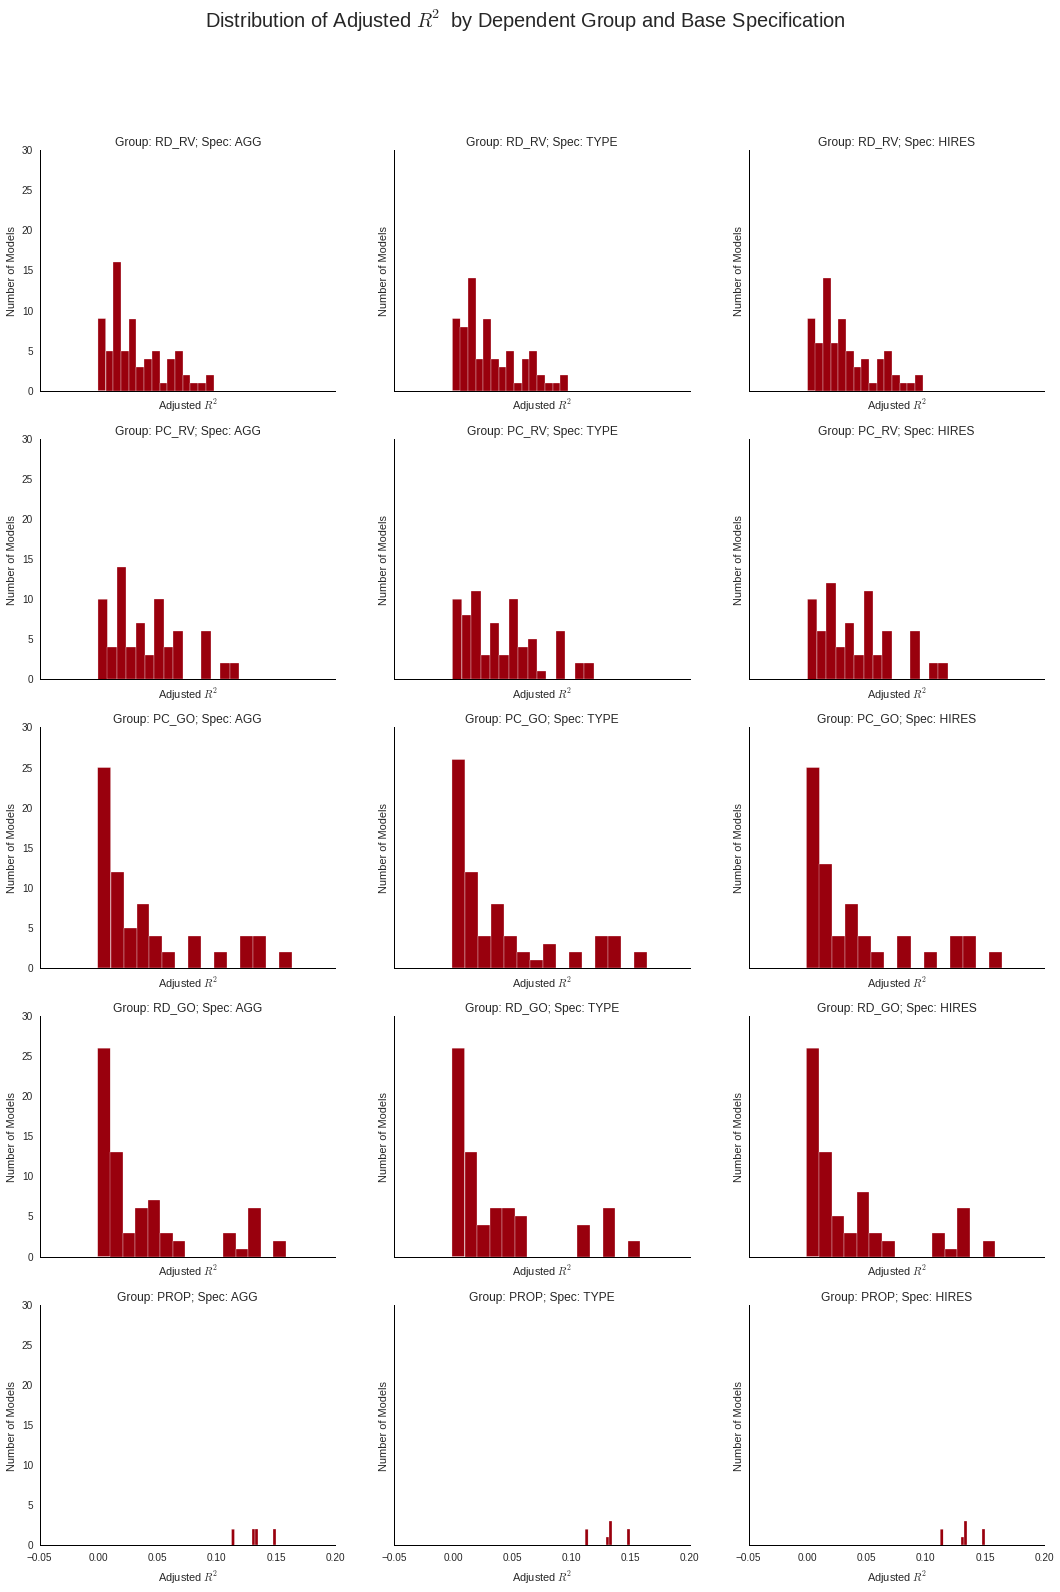

In [374]:
#Establish groups and model spec lists
groups=spec_dict.keys()
models=spec_dict['PC_GO']['Total'].keys()

#Generate plot object
fig,ax=plt.subplots(5,3,figsize=(18,25),sharex=True,sharey=True)

#For each group...
for i,grp in enumerate(groups):
    #...and each model spec...
    for j,model in enumerate(models):
        #...capture adjusted R squared from all models...
        r2_vec=np.array([mod.rsquared_adj for mod in mod_dict[grp][model]])
        #...and plot the histogram of adjust R squared
        ax[i,j].hist(r2_vec,color='#99000d',ec='w',bins=15)
        #...fix labels...
        ax[i,j].set_title('Group: '+grp+'; Spec: '+model)
        ax[i,j].set_xlabel('Adjusted $R^2$')
        ax[i,j].set_ylabel('Number of Models')
        #...fix axes
        simpleaxis(ax[i,j])
        
plt.suptitle('Distribution of Adjusted $R^2$ by Dependent Group and Base Specification',fontsize=20)

plt.savefig('../figures/r2_by_grp_spec.png',dpi=500,bbox_inches='tight')

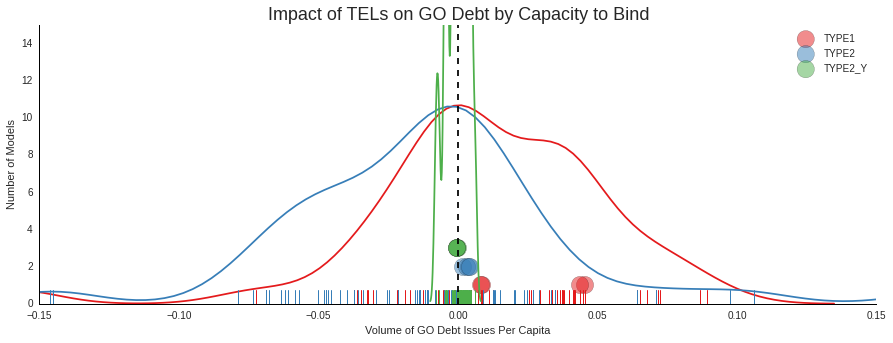

In [375]:
#Define dictionary to hold TEL variables by model
tel_dict={'TYPE':['TYPE1','TYPE2','TYPE2_Y'],
          'AGG':['LIMITS','BOTH'],
          'HIRES':['RATE_L','ASMT_L','GP_LMT','SC_LMT']}

#Establish list of colors
tel_cols=['#e41a1c','#377eb8','#4daf4a','#ff7f00']

def est_plot(dep_str,mod_str,data_highlight,ax=ax):
    #Create containers for density plots
    dplots=[]
    
    #For each TEL variable...
    for i,tvar in enumerate(tel_dict[mod_str]):
        #Capture data and dependent in tuples
        data_items=[(mod.params.ix[tvar],mod.model.endog_names) for mod in mod_dict[dep_str][mod_str]]
        #Capture the data in isolation
        data_vals=np.array([item[0] for item in data_items])
        #Capture data points associated with the dependents we wish to highlight
        data_hl=[item[0] for item in data_items if item[1]==data_highlight]
        #Plot density of coefficient estimates
        sb.distplot(data_vals,hist=False,rug=True,color=tel_cols[i],ax=ax)
        #Plot data highlight scatter
        p=ax.scatter(x=data_hl,y=[i+1 for val in data_hl],s=300,alpha=.5,c=tel_cols[i])
        #Capture plot
        dplots.append((p,tvar))
    #Generate zero line
    ax.axvline(x=0,color='k',linestyle='--')
    #Fix axes
    simpleaxis(ax)
    ax.legend([p[0] for p in dplots],[p[1] for p in dplots])
    
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_GO','TYPE','GO_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of GO Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TELs on GO Debt by Capacity to Bind',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,15])

plt.savefig('../figures/tel_on_go_debt_by_bind.png',dpi=500,bbox_inches='tight')

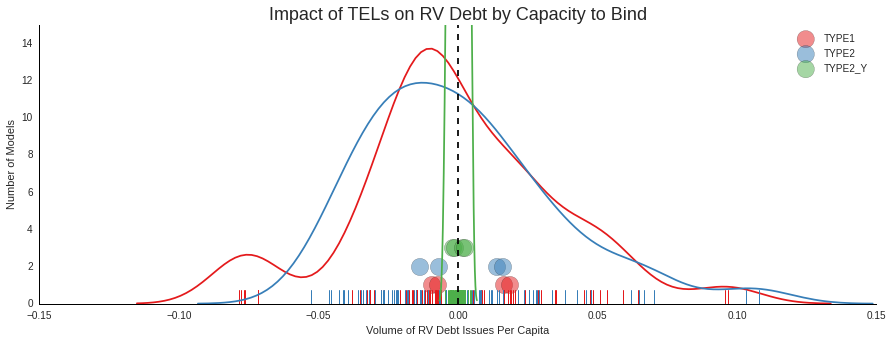

In [376]:
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_RV','TYPE','RV_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of RV Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TELs on RV Debt by Capacity to Bind',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,15])

plt.savefig('../figures/tel_on_rv_debt_by_bind.png',dpi=500,bbox_inches='tight')

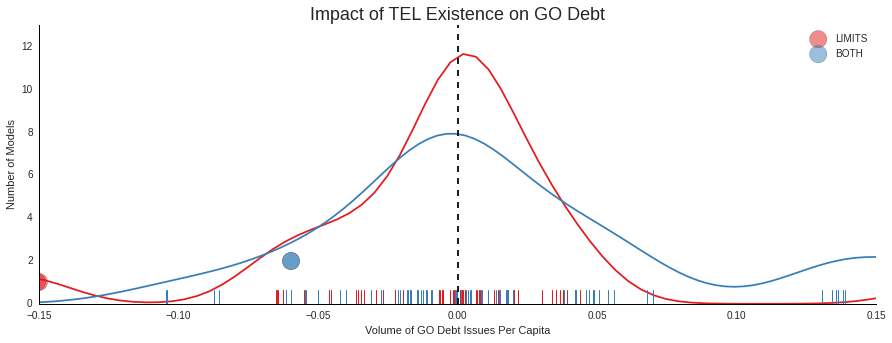

In [377]:
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_GO','AGG','GO_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of GO Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TEL Existence on GO Debt',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,13])

plt.savefig('../figures/tel_on_go_debt_by_exist.png',dpi=500,bbox_inches='tight')

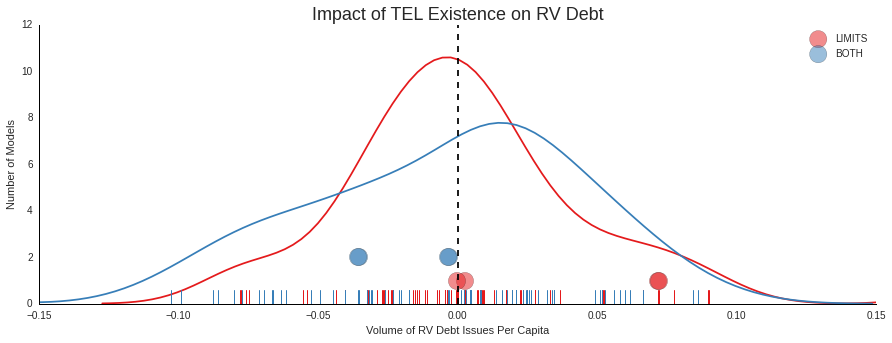

In [378]:
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_RV','AGG','RV_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of RV Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TEL Existence on RV Debt',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,12])

plt.savefig('../figures/tel_on_rv_debt_by_exist.png',dpi=500,bbox_inches='tight')

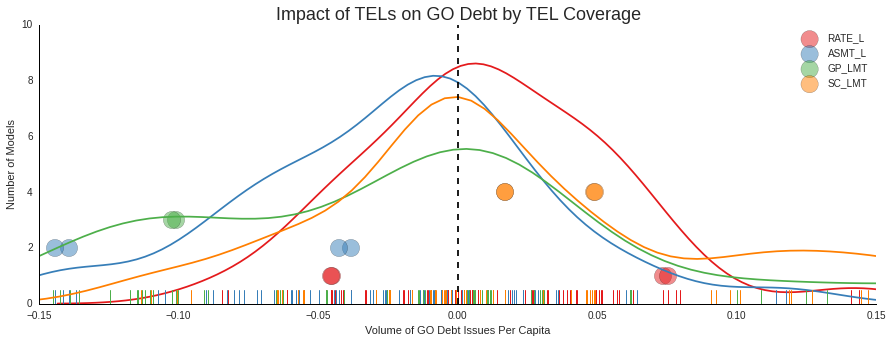

In [379]:
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_GO','HIRES','GO_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of GO Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TELs on GO Debt by TEL Coverage',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,10])

plt.savefig('../figures/tel_on_go_debt_by_cover.png',dpi=500,bbox_inches='tight')

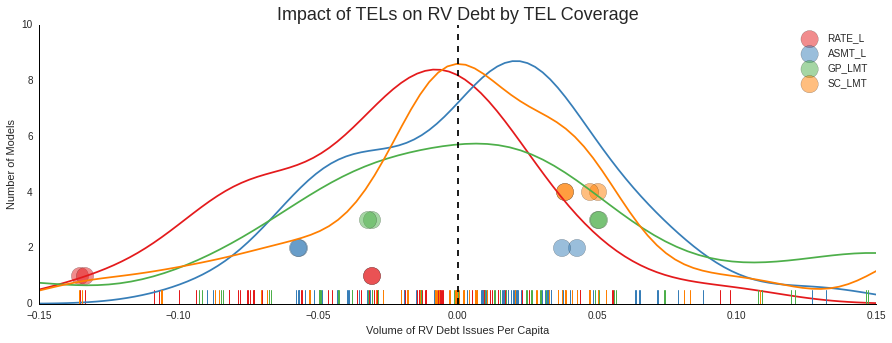

In [380]:
#Generate plot object
fig,ax=plt.subplots(figsize=(15,5))

#Plot per capita GO TEL estimates
est_plot('PC_RV','HIRES','RV_PC',ax=ax)

#Fix labels
ax.set_xlabel('Volume of RV Debt Issues Per Capita')
ax.set_ylabel('Number of Models')
ax.set_title('Impact of TELs on RV Debt by TEL Coverage',fontsize=18)

#Fix axes
ax.set_xlim([-.15,.15])
ax.set_ylim([0,10])

plt.savefig('../figures/tel_on_rv_debt_by_cover.png',dpi=500,bbox_inches='tight')